# Load Data

In [124]:
save_plots = True

In [125]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import special
from inspect import signature
from datetime import datetime
import time
from tqdm import tqdm
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as md

In [126]:
## Set plot styles

%matplotlib inline
plt.rcParams['figure.dpi'] = 200
matplotlib.rcParams['axes.linewidth'] = 0.75 #set the value globally
matplotlib.rcParams['xtick.major.width'] = 0.75
matplotlib.rcParams['ytick.major.width'] = 0.75
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['legend.fontsize'] =5
matplotlib.rcParams['pdf.fonttype']=42


matplotlib.rcParams['figure.figsize'] = (3.4908516673585166, 2.327234444905678)
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rc('font', size= 7)
#params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
#plt.rcParams.update(params)

In [127]:
! ls Th228_far/*.Spe

Th228_far/Th228_far_20231101_0_000.Spe Th228_far/Th228_far_20231101_0_028.Spe
Th228_far/Th228_far_20231101_0_001.Spe Th228_far/Th228_far_20231101_0_029.Spe
Th228_far/Th228_far_20231101_0_002.Spe Th228_far/Th228_far_20231101_0_030.Spe
Th228_far/Th228_far_20231101_0_003.Spe Th228_far/Th228_far_20231101_0_031.Spe
Th228_far/Th228_far_20231101_0_004.Spe Th228_far/Th228_far_20231101_0_032.Spe
Th228_far/Th228_far_20231101_0_005.Spe Th228_far/Th228_far_20231101_0_033.Spe
Th228_far/Th228_far_20231101_0_006.Spe Th228_far/Th228_far_20231101_0_034.Spe
Th228_far/Th228_far_20231101_0_007.Spe Th228_far/Th228_far_20231101_0_035.Spe
Th228_far/Th228_far_20231101_0_008.Spe Th228_far/Th228_far_20231101_0_036.Spe
Th228_far/Th228_far_20231101_0_009.Spe Th228_far/Th228_far_20231101_0_037.Spe
Th228_far/Th228_far_20231101_0_010.Spe Th228_far/Th228_far_20231101_0_038.Spe
Th228_far/Th228_far_20231101_0_011.Spe Th228_far/Th228_far_20231101_0_039.Spe
Th228_far/Th228_far_20231101_0_012.Spe Th228_far/Th228_far_20231

In [128]:
#path = '.'
files_list = glob.glob('Th228_far/*')
print(files_list)
filename_suffix_save = 'Th228_20231101'

['Th228_far/Th228_far_20231101_0_048.Spe', 'Th228_far/Th228_far_20231101_0_049.Spe', 'Th228_far/Th228_far_20231101_0_003.Spe', 'Th228_far/Th228_far_20231101_0_017.Spe', 'Th228_far/Th228_far_20231101_0_016.Spe', 'Th228_far/Th228_far_20231101_0_002.Spe', 'Th228_far/Th228_far_20231101_0_028.Spe', 'Th228_far/Th228_far_20231101_0_014.Spe', 'Th228_far/Th228_far_20231101_0_000.Spe', 'Th228_far/Th228_far_20231101_0_001.Spe', 'Th228_far/Th228_far_20231101_0_015.Spe', 'Th228_far/Th228_far_20231101_0_029.Spe', 'Th228_far/Th228_far_20231101_0_011.Spe', 'Th228_far/Th228_far_20231101_0_005.Spe', 'Th228_far/Th228_far_20231101_0_039.Spe', 'Th228_far/Th228_far_20231101_0_038.Spe', 'Th228_far/Th228_far_20231101_0_004.Spe', 'Th228_far/Th228_far_20231101_0_010.Spe', 'Th228_far/Th228_far_20231101_0_006.Spe', 'Th228_far/Th228_far_20231101_0_012.Spe', 'Th228_far/Th228_far_20231101_0_013.Spe', 'Th228_far/Th228_far_20231101_0_007.Spe', 'Th228_far/Th228_far_20231101_0_022.Spe', 'Th228_far/Th228_far_20231101_0_0

In [129]:
def load_file(file):
    number_lines_header = 12 ## There are 12 header lines in the SPE file
    counts_list = []

    with open(file) as fp:
        for i, line in enumerate(fp):
            line = line.rstrip('\n')
            if i == 1: ## description of the sample
                descr = line
                #print(descr)
            elif i == 7: ## starting acquisition time
                string_time = line
                #print(string_time)
                # TODO: convert to UNIX time
            elif i == 9: ## acquisition time
                live_time = int(line.split(' ')[0]) ## acquisition live time in seconds (without dead time)
                real_time = int(line.split(' ')[1]) ## acquisition real time in seconds
                #print(live_time, real_time)
            elif i == 11: ## channel numbers
                first_channel = int(line.split(' ')[0]) ## number of first channel, usually 0
                last_channel = int(line.split(' ')[1]) ## number of last channel, usually 16383 (= 2^14-1)
                #print(first_channel, last_channel)
            elif (i >= number_lines_header):
                if (i<=last_channel+number_lines_header):
                    counts_list.append(int(line))
                elif i > last_channel+number_lines_header:
                    break

    channels_list = np.arange(0, last_channel+1)
    df = pd.DataFrame(data={'channel': channels_list, 'counts': counts_list})
    
    return df, live_time, string_time, descr

def load_files(files_list):
    for i_file, file in enumerate(files_list):
        if i_file == 0:
            df_combined, live_time_combined = load_file(file)[0:2]
        else:
            df_temp, live_time_temp = load_file(file)[0:2]
            if len(df_combined) == len(df_temp):
                df_combined.counts = df_combined.counts + df_temp.counts
                live_time_combined = live_time_combined + live_time_temp
            else:
                raise ValueError("file "+str(file)+" has different number of channels compared to previous file")
                
    print('total live time = '+str(live_time_combined)+' s = '+str(live_time_combined/(24*60*60))+' d')
    return df_combined, live_time_combined

In [130]:
df, total_live_time = load_files(files_list)
df

total live time = 49049 s = 0.5676967592592592 d


,channel,counts
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
16379,16379,0
16380,16380,0
16381,16381,0
16382,16382,0


In [131]:
## Trigger Rate [s^-1]
df.loc[545:16380].counts.sum()/total_live_time

18.459948215050257

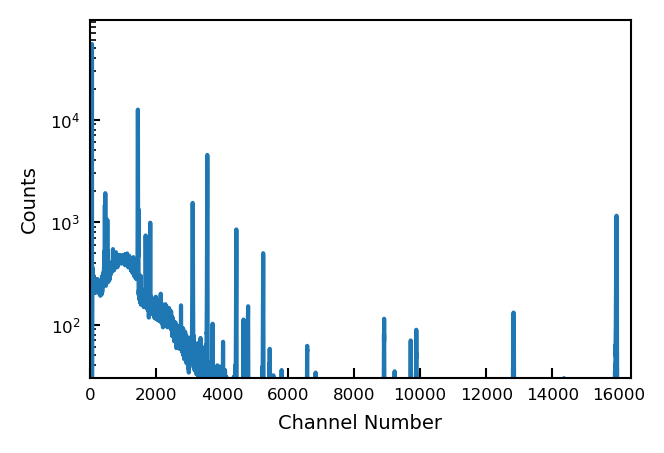

In [132]:
plt.plot(df.channel, df.counts)
plt.yscale('log')
plt.xlim(0,16383)
plt.ylim(bottom = 30)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
plt.show()

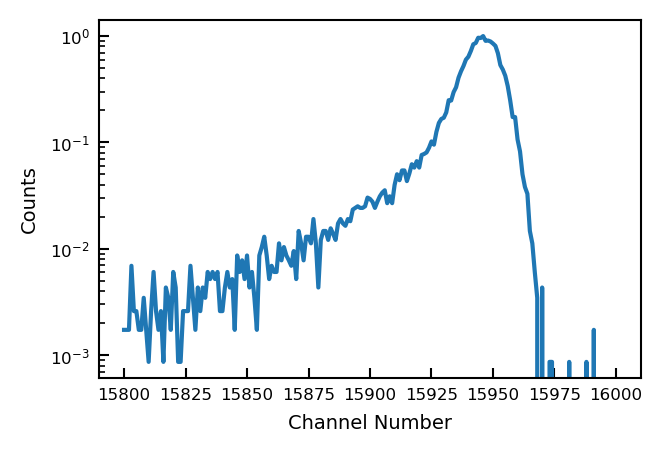

In [133]:
df1 = df.loc[15800:16000]
maxcount = df1.counts.max()

plt.plot(df1.channel, df1.counts/maxcount)
plt.yscale('log')
#plt.ylim(bottom = 30)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
plt.show()

# Fit Individual Peaks

In [134]:
def gausFunc(E, Gamma,P,sigma,C):
    gaus = Gamma * np.exp(-(E-P)**2/(2*sigma**2)) + C
    return gaus

#def tailFunc(E, Gamma,P,sigma,beta,C):
#    tail = Gamma * np.exp((E-P)/beta)*special.erfc(((E-P)/beta)+(sigma/(np.sqrt(2)*beta))) + C
#    return tail

from scipy.stats import crystalball
def crystalballFunc(E, Gamma,P,sigma,alpha,n,C):
    ## https://scipy.github.io/devdocs/generated/scipy.stats.crystalball.html
    crys = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + C
    return crys

def stepFunc(E, S,P,sigma,C):
    step = S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + C
    return step

def linFunc(E, m,q):
    lin = m*E+q
    return lin

def gausStepFunc(E, Gamma,S,P,sigma,C):
    gausStep = Gamma * np.exp(-(E-P)**2/(2*sigma**2)) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + C
    return gausStep

def fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q
    return res

In [135]:
df_calibration = pd.DataFrame(data={'name': [], 'e_lit': [], 'e_err_lit': [], 
                                    'peak_position': [], 'peak_position_unc': [], 
                                    'peak_width': [], 'peak_width_unc': [], 
                                    'chi2_dof': [], 'channel_max': []})

## Pb238

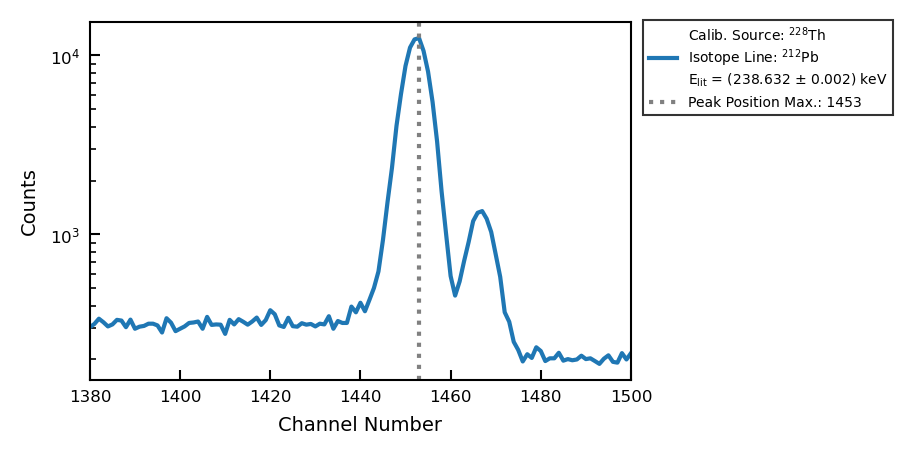

In [136]:
name = 'Pb238'
isotope = '$^{212}$Pb'
e_lit = 238.632 #keV
e_err_lit = 0.002 #keV

#######################
## Adjust these values if necessary:
lower_channel = 1380
upper_channel = 1500
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [137]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = 0
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-0.1,0.1]
limits_q = [-np.inf,+np.inf]

In [138]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

[ 8.61259964e+04  1.45232512e+03  2.85320322e+00  9.95000050e+02
  2.61252320e+02  2.74910152e+01 -1.00000000e-01  4.11210569e+02]


/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


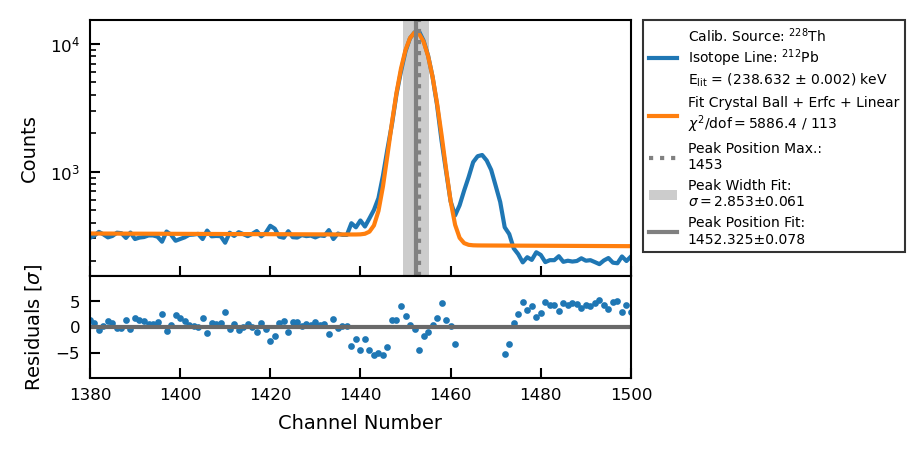

In [139]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-10,10)
ax1.set_yticks(np.arange(-5, 5.1, step=5))
#yticks[-1].label1.set_visible(False)
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()

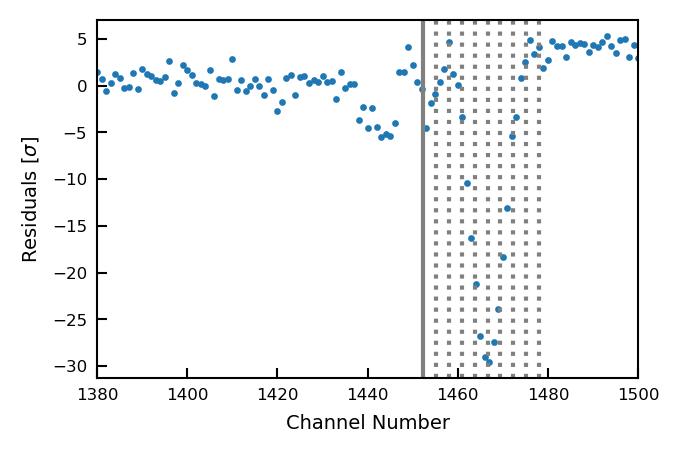

In [140]:
plt.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
plt.axvline(peak_position, linestyle='-', color = 'gray')
for i in range(1,10):
    plt.axvline(peak_position+i*peak_width, linestyle='dotted', color = 'gray')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Residuals [$\sigma$]')
plt.show()

**Comment:** little peak from Ra-224 at ~240keV above Pb-212 peak affects the fit -> add additional Gaussian with clever fit constraints.

In [141]:
def fitFunc238(E, Gamma,P,sigma,alpha,n,S,m,q, Gamma2,P2,sigma2):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q + (Gamma2 * np.exp(-(E-P2)**2/(2*sigma2**2)))
    return res

In [142]:
guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,_,_,_ = popt
#guess_sigma = popt[2]

guess_P2 = popt[1] + 5*popt[2]
guess_Gamma2 = (val_max - high_med)/10
guess_sigma2 = popt[2]

limits_P2 = [popt[1] + 3*popt[2], min(popt[1]+7*popt[2], upper_channel)]
limits_Gamma2 = [1, (val_max - high_med)/2]
limits_sigma2 = [0.5, min(2*popt[2], 100,(upper_channel-lower_channel)/2)]

In [143]:
## Total Fit
popt, pcov = curve_fit(fitFunc238, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q,guess_Gamma2,guess_P2,guess_sigma2], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0],limits_Gamma2[0],limits_P2[0],limits_sigma2[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1],limits_Gamma2[1],limits_P2[1],limits_sigma2[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])
peak2_position = popt[9]
peak2_position_unc = np.sqrt(pcov[9,9])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc238(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc238(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[8.64088476e+04 1.45237438e+03 2.79221519e+00 1.64538646e+00
 1.55943114e+02 6.09495263e+01 9.92473613e-02 5.71433914e+01
 1.14560426e+03 1.46666979e+03 2.84817278e+00]
Appending data for Pb238 to df_calibration.


/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_2585/85123737.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


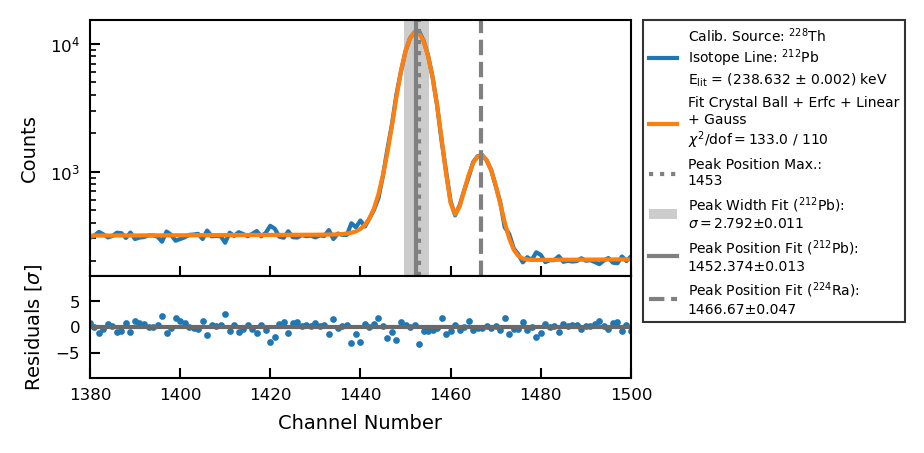

In [144]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc238(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n+ Gauss\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit ('+isotope+'): \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit ('+isotope+'):\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.axvline(peak2_position, linestyle='dashed', color = 'gray', 
            label='Peak Position Fit ($^{224}$Ra):\n'+str(round(peak2_position,3))+'±'+str(round(peak2_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-10,10)
ax1.set_yticks(np.arange(-5, 5.1, step=5))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()

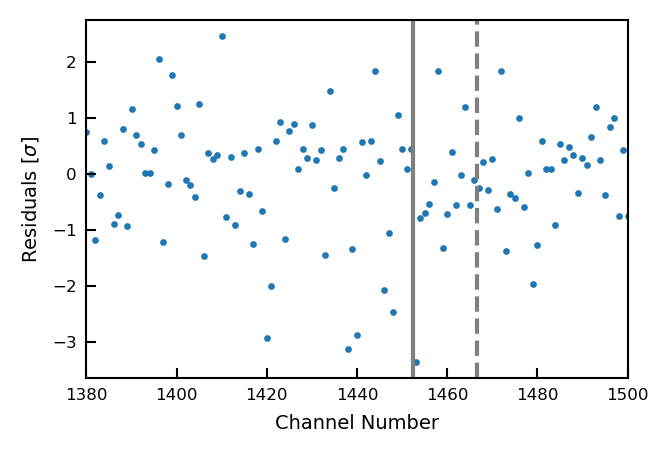

In [145]:
plt.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
plt.axvline(peak_position, linestyle='-', color = 'gray')
plt.axvline(peak2_position, linestyle='dashed', color = 'gray')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Residuals [$\sigma$]')
plt.show()

**Comment:** there seems to be a little bump below the main peak as well (what is it?) -> add additional Gaussian with clever fit constraints.

In [146]:
def fitFunc238_2(E, Gamma,P,sigma,alpha,n,S,m,q, Gamma2,P2,sigma2, Gamma3,P3,sigma3):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q + (Gamma2 * np.exp(-(E-P2)**2/(2*sigma2**2))) + (Gamma3 * np.exp(-(E-P3)**2/(2*sigma3**2)))
    return res

In [147]:
guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q,guess_Gamma2,guess_P2,guess_sigma2 = popt

In [148]:
guess_P3 = popt[1] - 5*popt[2]
guess_Gamma3 = (val_max - low_med/2)/100
guess_sigma3 = popt[2]

limits_P3 = [(lower_channel+popt[1])/2, popt[1] - 2*popt[2]]
limits_Gamma3 = [0, (val_max - (low_med+high_med)/2)/10]
limits_sigma3 = [0.5, min(10*popt[2], 100,(upper_channel-lower_channel)/2)]

In [149]:
## Total Fit
popt, pcov = curve_fit(fitFunc238_2, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q,guess_Gamma2,guess_P2,guess_sigma2,guess_Gamma3,guess_P3,guess_sigma3], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0],limits_Gamma2[0],limits_P2[0],limits_sigma2[0],limits_Gamma3[0],limits_P3[0],limits_sigma3[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1],limits_Gamma2[1],limits_P2[1],limits_sigma2[1],limits_Gamma3[1],limits_P3[1],limits_sigma3[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])
peak2_position = popt[9]
peak2_position_unc = np.sqrt(pcov[9,9])
peak3_position = popt[12]
peak3_position_unc = np.sqrt(pcov[12,12])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc238_2(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc238_2(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[8.64088483e+04 1.45236881e+03 2.79712380e+00 1.68815534e+00
 1.56667595e+02 5.88128330e+01 9.92880048e-02 5.71447875e+01
 1.14605531e+03 1.46667148e+03 2.84555864e+00 1.14529575e+02
 1.43910896e+03 1.24635905e+00]
Entry for Pb238 already in df_calibration, will overwrite it!


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_2585/3302618251.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


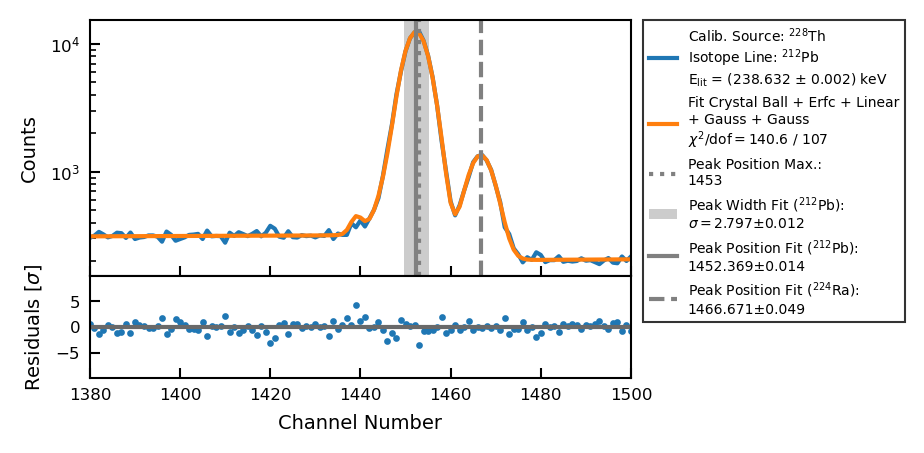

In [150]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc238_2(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n+ Gauss + Gauss\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit ('+isotope+'): \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit ('+isotope+'):\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.axvline(peak2_position, linestyle='dashed', color = 'gray', 
            label='Peak Position Fit ($^{224}$Ra):\n'+str(round(peak2_position,3))+'±'+str(round(peak2_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-10,10)
ax1.set_yticks(np.arange(-5, 5.1, step=5))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

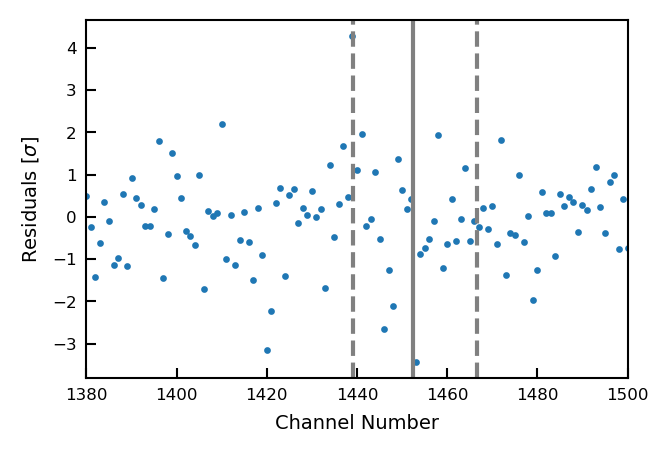

In [151]:
plt.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
plt.axvline(peak_position, linestyle='-', color = 'gray')
plt.axvline(peak2_position, linestyle='dashed', color = 'gray')
plt.axvline(peak3_position, linestyle='dashed', color = 'gray')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Residuals [$\sigma$]')
plt.show()

## Tl 277

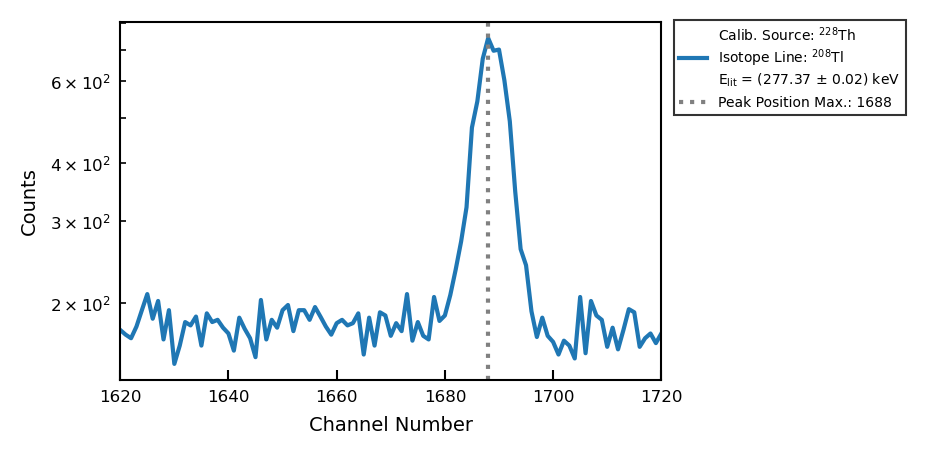

In [152]:
name = 'Tl277'
isotope = '$^{208}$Tl'
e_lit = 277.37 #keV
e_err_lit = 0.02 #keV

#######################
## Adjust these values if necessary:
lower_channel = 1620
upper_channel = 1720
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [153]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,0]
limits_q = [-np.inf,+np.inf]

In [154]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 4.19503606e+03  1.68863362e+03  2.95112871e+00  9.97141139e+02
  2.68449596e+01  4.05986450e+00 -1.76077011e-15  1.71161395e+02]
Appending data for Tl277 to df_calibration.


/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_2585/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


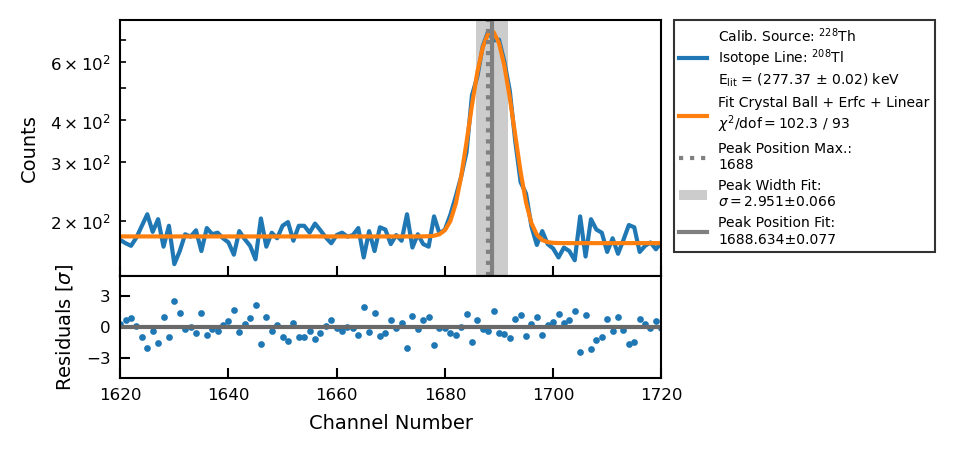

In [155]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Pb 300

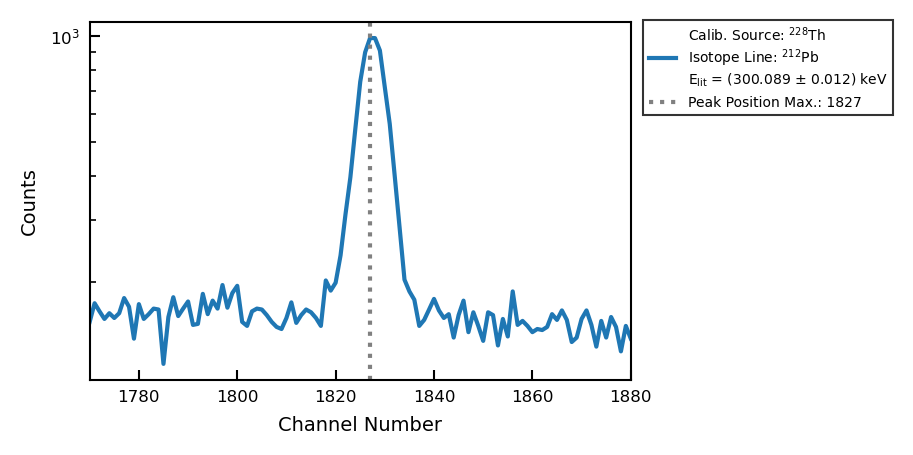

In [156]:
name = 'Pb300'
isotope = '$^{212}$Pb'
e_lit = 300.089 #keV
e_err_lit = 0.012 #keV

#######################
## Adjust these values if necessary:
lower_channel = 1770
upper_channel = 1880
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [157]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [158]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 6.07487388e+03  1.82748410e+03  2.88300312e+00  2.28402826e+01
  9.94286197e+02  2.62749256e+00 -9.82894691e-02  3.34530802e+02]
Appending data for Pb300 to df_calibration.


/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_2585/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


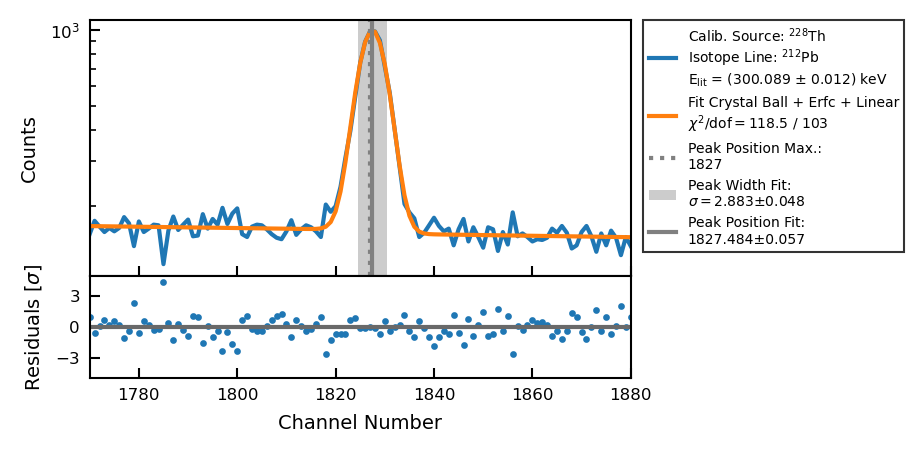

In [159]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Tl 583

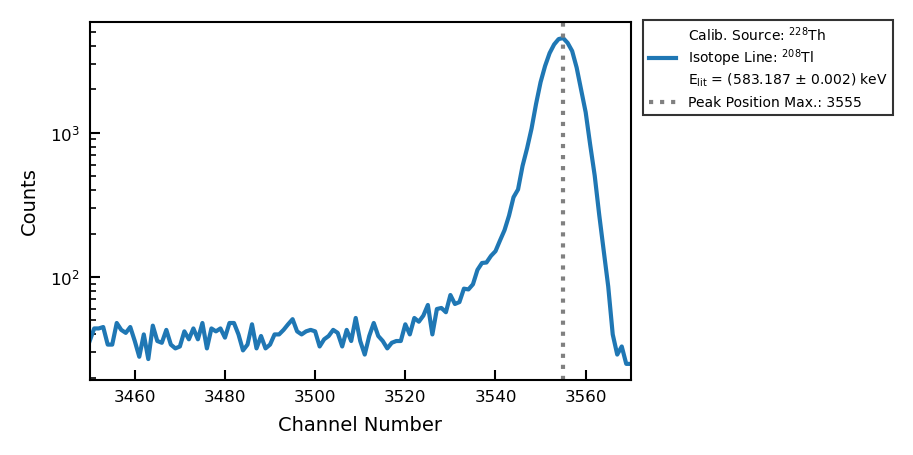

In [160]:
name = 'Tl583'
isotope = '$^{208}$Tl'
e_lit = 583.187 #keV
e_err_lit = 0.002 #keV

#######################
## Adjust these values if necessary:
lower_channel = 3450
upper_channel = 3570
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [161]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 5 ##random guess, seems to work
guess_n = 5. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [162]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 4.33492226e+04  3.55439799e+03  3.60057567e+00  1.44368168e+00
  3.52248617e+00  5.03365051e+00 -5.23948574e-02  2.09491817e+02]
Appending data for Tl583 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_2585/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


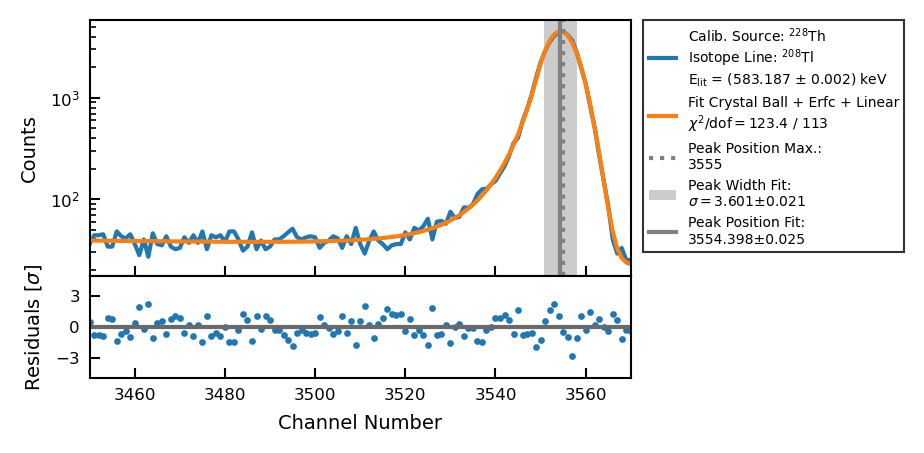

In [163]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Bi 727

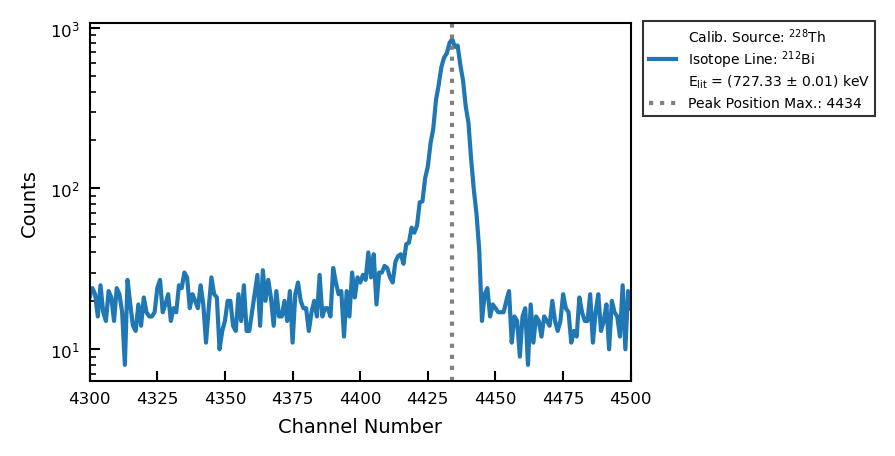

In [164]:
name = 'Bi727'
isotope = '$^{212}$Bi'
e_lit = 727.33 #keV
e_err_lit = 0.01 #keV

#######################
## Adjust these values if necessary:
lower_channel = 4300
upper_channel = 4500
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [165]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit 
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 5. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel) 
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [166]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[8.81903766e+03 4.43358617e+03 3.99042943e+00 1.47623094e+00
 2.39647432e+00 1.32917476e+00 8.10013288e-04 1.12664318e+01]
Appending data for Bi727 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_2585/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


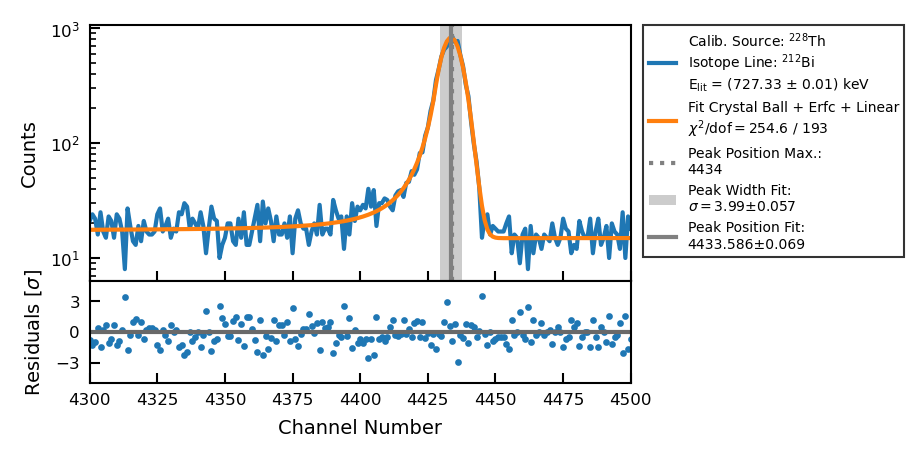

In [167]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()

**Comment:** little peak from Tl-208 at ~727keV below Bi-212 peak might slightly affect the fit (deviation maximum position and position from fit > 0.5 bins) -> add additional Gaussian with clever fit constraints.

In [168]:
def fitFunc727(E, Gamma,P,sigma,alpha,n,S,m,q, Gamma2,P2,sigma2):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q + (Gamma2 * np.exp(-(E-P2)**2/(2*sigma2**2)))
    return res

In [169]:
guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q = popt

guess_P2 = popt[1] - 10*popt[2]
guess_Gamma2 = (val_max - (low_med+high_med)/2)/100
guess_sigma2 = popt[2]

limits_P2 = [(lower_channel+popt[1])/2, popt[1] - 2*popt[2]]
limits_Gamma2 = [0, (val_max - (low_med+high_med)/2)/10]
limits_sigma2 = [0.5, min(10*popt[2], 100,(upper_channel-lower_channel)/2)]

In [170]:
## Total Fit
popt, pcov = curve_fit(fitFunc727, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q,guess_Gamma2,guess_P2,guess_sigma2], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0],limits_Gamma2[0],limits_P2[0],limits_sigma2[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1],limits_Gamma2[1],limits_P2[1],limits_sigma2[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])
peak2_position = popt[9]
peak2_position_unc = np.sqrt(pcov[9,9])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc727(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc727(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[8.40782110e+03 4.43366729e+03 3.93013851e+00 1.18588375e+00
 1.30871514e+02 1.53525018e+00 5.15050184e-04 1.26219762e+01
 1.22385545e+01 4.41211872e+03 1.09372394e+01]
Entry for Bi727 already in df_calibration, will overwrite it!


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_2585/2813564560.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


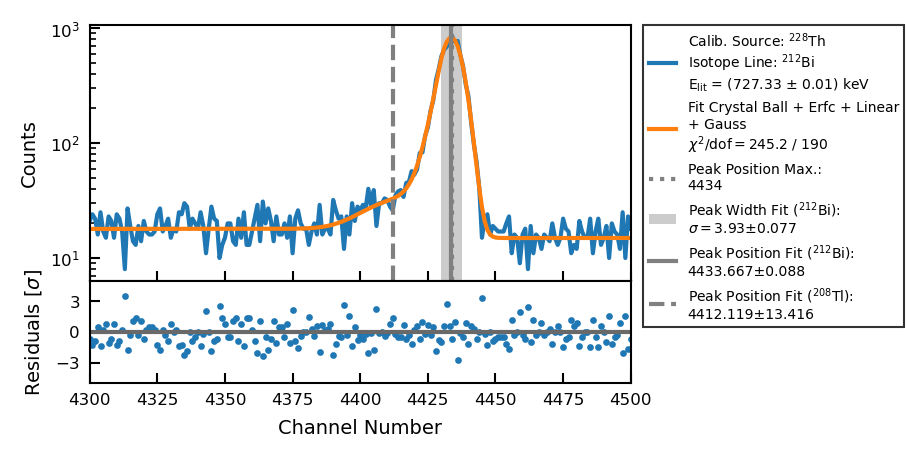

In [171]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc727(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n+ Gauss\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit ('+isotope+'): \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit ('+isotope+'):\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.axvline(peak2_position, linestyle='dashed', color = 'gray', 
            label='Peak Position Fit ($^{208}$Tl):\n'+str(round(peak2_position,3))+'±'+str(round(peak2_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Bi 763

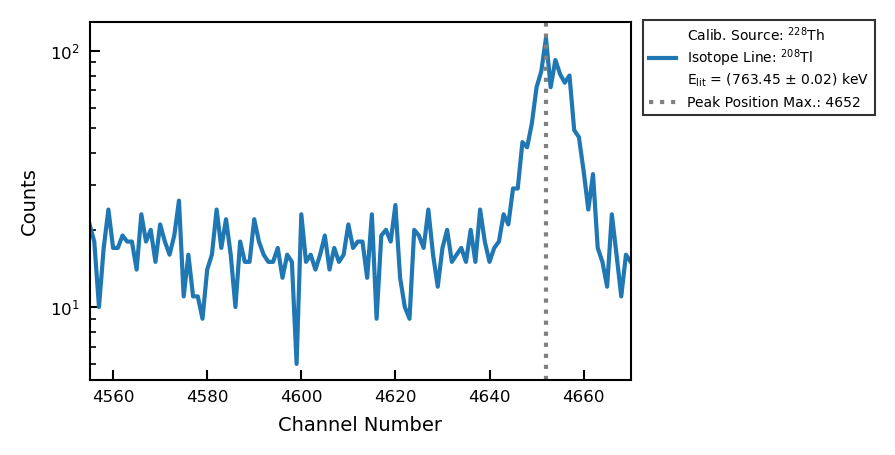

In [172]:
name = 'Bi763'
isotope = '$^{208}$Tl'
e_lit = 763.45 #keV
e_err_lit = 0.02 #keV

#######################
## Adjust these values if necessary:
lower_channel = 4555
upper_channel = 4670
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [173]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = 0# (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.4, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 100]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-0.1,+0.1] #[-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [174]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 7.81987448e+02  4.65336966e+03  4.15734279e+00  4.16467774e+02
  4.27030293e+01  8.46518303e-01 -9.61810704e-04  1.84477758e+01]
Appending data for Bi763 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_2585/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


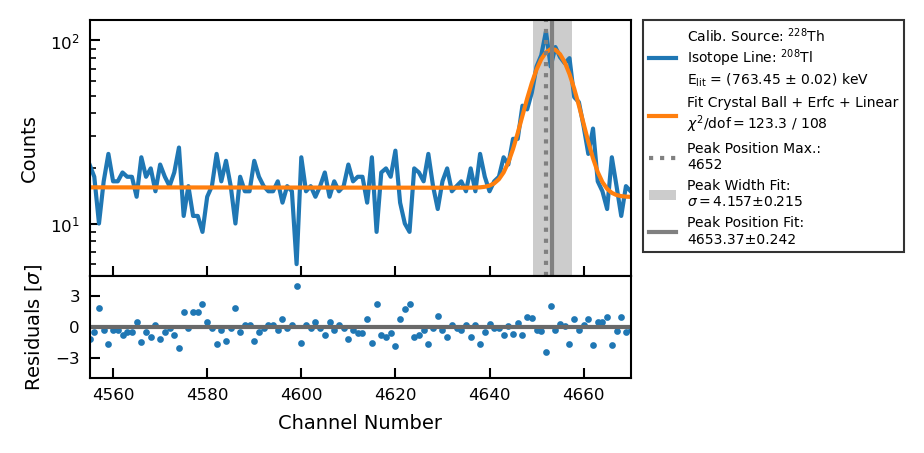

In [175]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Bi 785

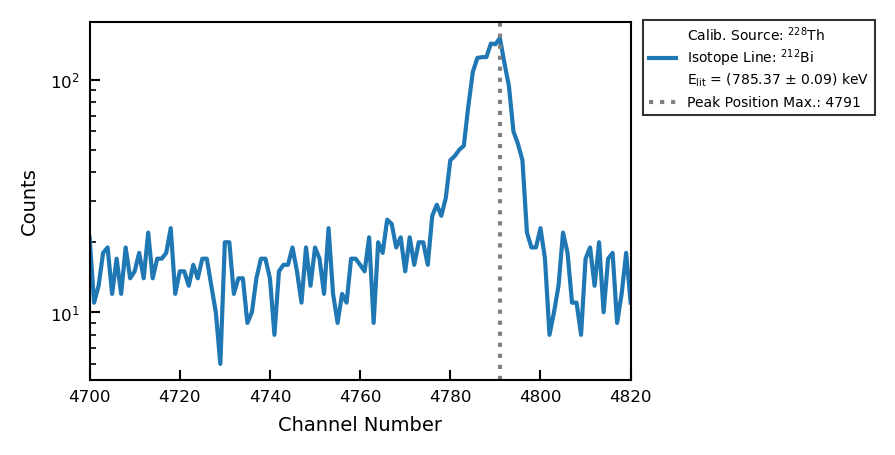

In [176]:
name = 'Bi785'
isotope = '$^{212}$Bi'
e_lit = 785.37 #keV
e_err_lit = 0.09 #keV

#######################
## Adjust these values if necessary:
lower_channel = 4700
upper_channel = 4820
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [177]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.05, 100]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [178]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 1.34161066e+03  4.78871363e+03  4.18219933e+00  2.13138384e+02
  5.99424323e+01  2.50000000e+00  3.89166102e-02 -1.74500856e+02]
Appending data for Bi785 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_2585/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


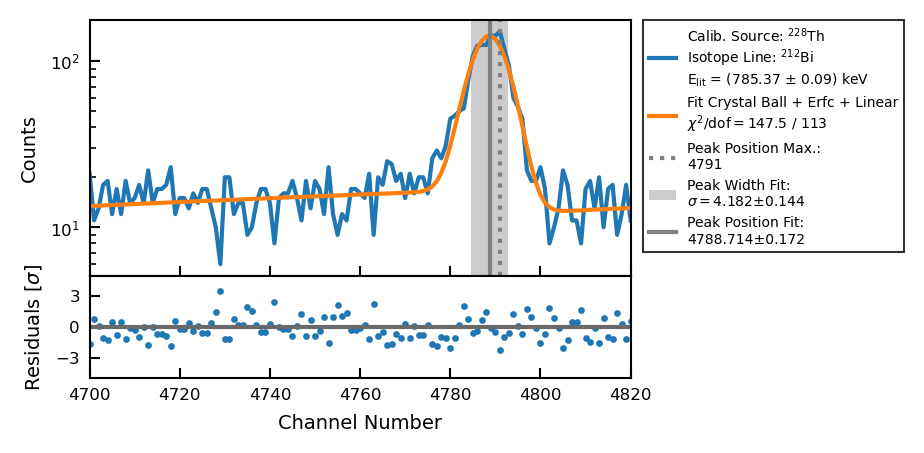

In [179]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Tl 860

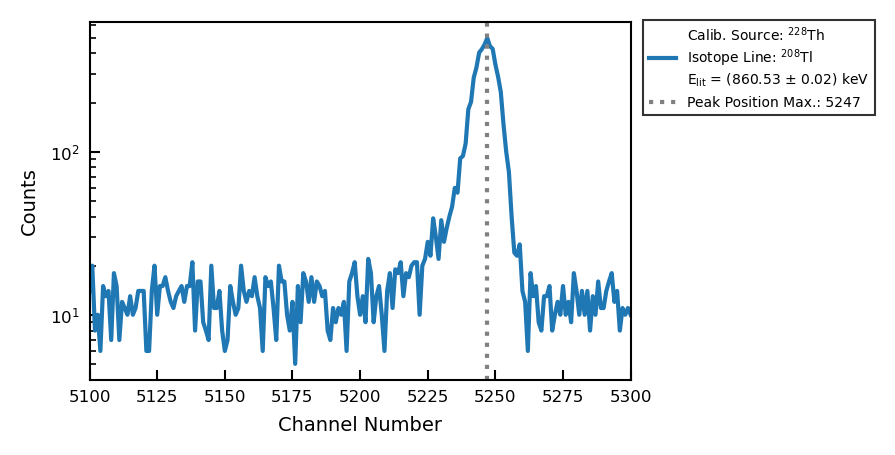

In [180]:
name = 'Tl860'
isotope = '$^{208}$Tl'
e_lit = 860.53 #keV
e_err_lit = 0.02 #keV

#######################
## Adjust these values if necessary:
lower_channel = 5100
upper_channel = 5300
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [181]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 50. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [182]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 5.39018664e+03  5.24655176e+03  4.15462297e+00  1.30299666e+00
  3.02817680e+00 -3.83338679e-01 -3.56847537e-03  3.00955593e+01]
Appending data for Tl860 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_2585/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


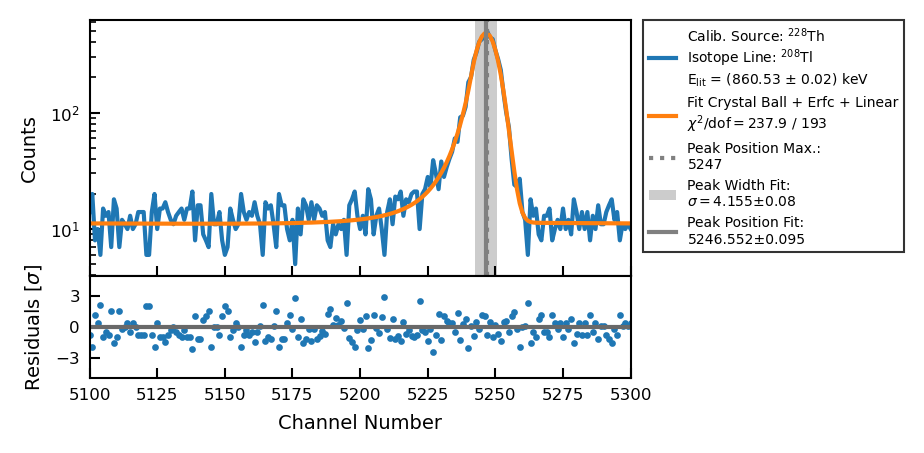

In [183]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Bi 1620

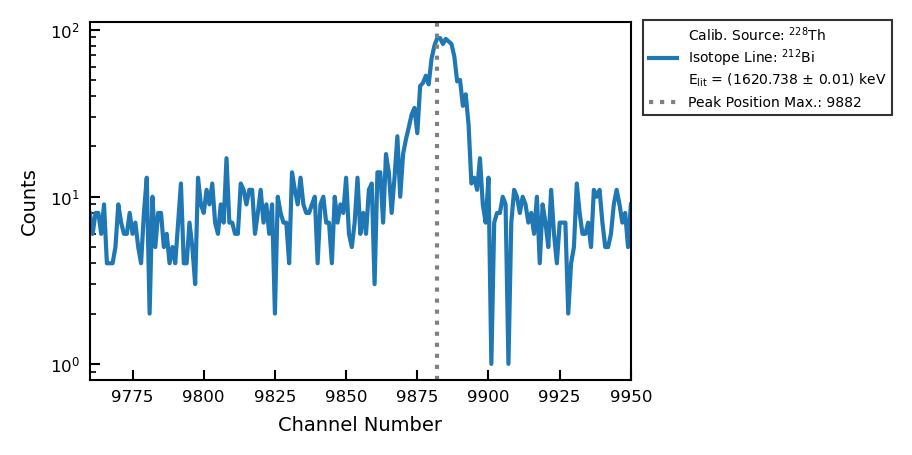

In [184]:
name = 'Bi1620'
isotope = '$^{212}$Bi'
e_lit = 1620.738 #keV
e_err_lit = 0.010 #keV

#######################
## Adjust these values if necessary:
lower_channel = 9760
upper_channel = 9950
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [185]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 5. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.05, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

'''## Improve guess/limits parameter sigma from Gauss+Step fit
try:
    popt, pcov = curve_fit(gausStepFunc, df_sel_peak.channel, df_sel_peak.counts, 
                           p0=[guess_Gamma, guess_S, guess_P, guess_sigma, (low_med+high_med)/2], 
                           bounds=((limits_Gamma[0], limits_S[0], limits_P[0], limits_sigma[0], 1.1*val_min-0.1*val_max),
                                   (limits_Gamma[1], limits_S[1], limits_P[1], limits_sigma[1], val_max)), 
                           sigma=df_sel_peak.counts_err, maxfev=10000)
    _,_,_,guess_sigma,_ = popt
    limits_sigma[1] = min(5*guess_sigma, limits_sigma[1])
except:
    print('Warning: gausStepFunc failed!')''';

In [186]:
'''df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
plt.plot(df_sel_peak.channel, gausStepFunc(df_sel_peak.channel, *popt), 
         label='Fit Gauss + Erfc')

plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
plt.axvspan(popt[2]-popt[3], popt[2]+popt[3], alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(popt[3],3))+'±'+str(round(np.sqrt(pcov[3,3]),3)))
plt.axvline(popt[2], linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(popt[2],3))+'±'+str(round(np.sqrt(pcov[2,2]),3)))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()''';

In [187]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
'''if np.abs(peak_width-guess_sigma)/peak_width > 0.2:
    print('Warning: Final peak width deviates from gausStepFunc peak width by '+str(round(100*np.abs(peak_width-guess_sigma)/peak_width,1))+' %')'''
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 1.11733716e+03  9.88358305e+03  5.65655319e+00  9.21022644e+02
  3.08721900e+01  2.50000000e+00  3.35018562e-02 -3.26903026e+02]
Appending data for Bi1620 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_2585/2228432332.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


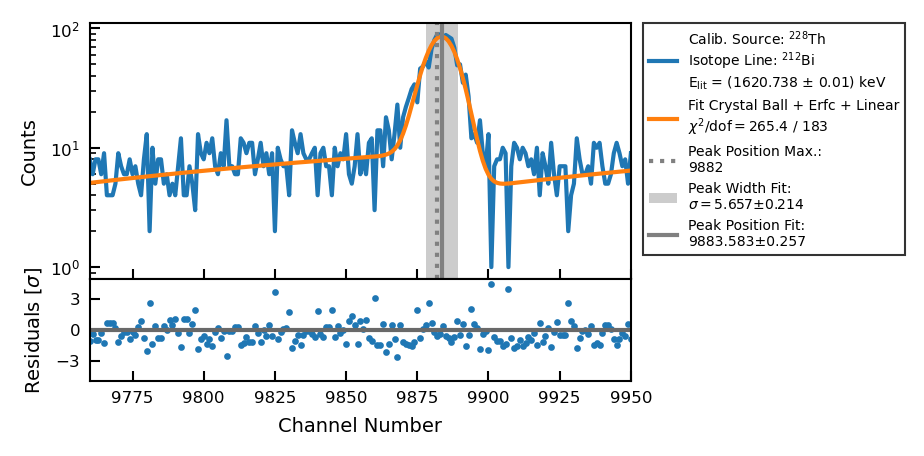

In [188]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Tl 2614

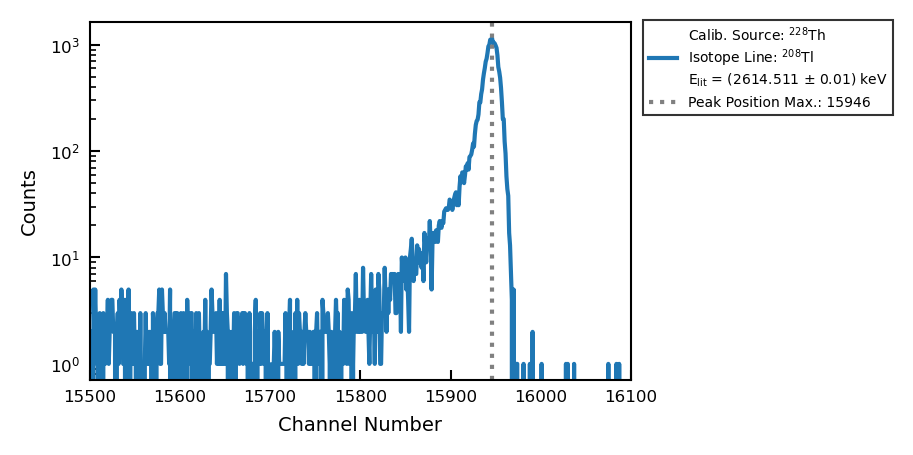

In [189]:
name = 'Tl2614'
isotope = '$^{208}$Tl'
e_lit = 2614.511 #keV
e_err_lit = 0.010 #keV

#######################
## Adjust these values if necessary:
lower_channel = 15500
upper_channel = 16100
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [190]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 10. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.05, 1000]
limits_n = [0.01, 1000]
limits_S = [-2*guess_S-0.01,2*guess_S+0.01]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [191]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 2.30514291e+04  1.59458791e+04  6.73033751e+00  1.12589748e+00
  2.33986883e+00 -5.64851228e-01 -4.28189483e-03  6.87098061e+01]
Appending data for Tl2614 to df_calibration.


/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_2585/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


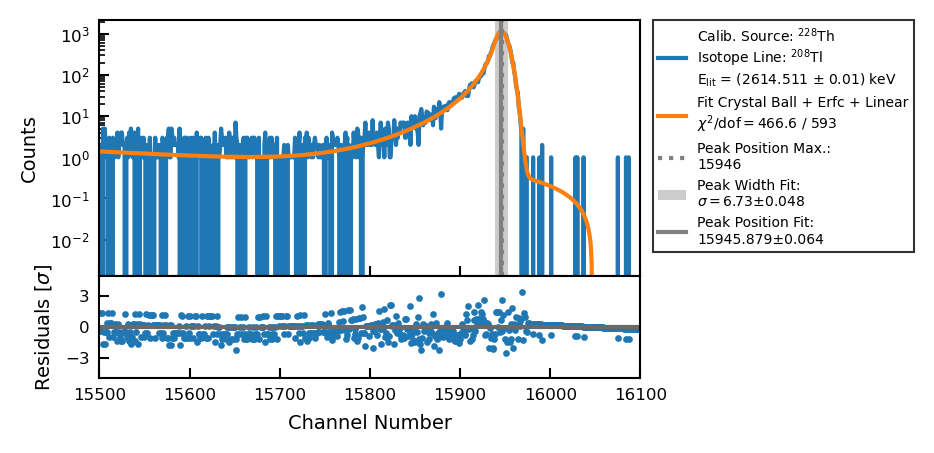

In [192]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

# Quality Checks

In [193]:
df_calibration

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max
0,Pb238,238.632,0.002,1452.368805,0.013606,2.797124,0.011871,1.313987,1453.0
1,Tl277,277.370,0.020,1688.633622,0.076545,2.951129,0.065978,1.100181,1688.0
2,Pb300,300.089,0.012,1827.484098,0.057109,2.883003,0.047617,1.150395,1827.0
3,Tl583,583.187,0.002,3554.397987,0.024547,3.600576,0.020904,1.092073,3555.0
4,Bi727,727.330,0.010,4433.667286,0.088468,3.930139,0.077443,1.290583,4434.0
5,Bi763,763.450,0.020,4653.369663,0.242035,4.157343,0.215254,1.141774,4652.0
6,Bi785,785.370,0.090,4788.713633,0.171520,4.182199,0.144335,1.305174,4791.0
7,Tl860,860.530,0.020,5246.551764,0.095075,4.154623,0.079725,1.232518,5247.0
8,Bi1620,1620.738,0.010,9883.583046,0.257435,5.656553,0.213653,1.450512,9882.0
9,Tl2614,2614.511,0.010,15945.879114,0.064350,6.730338,0.048223,0.786811,15946.0


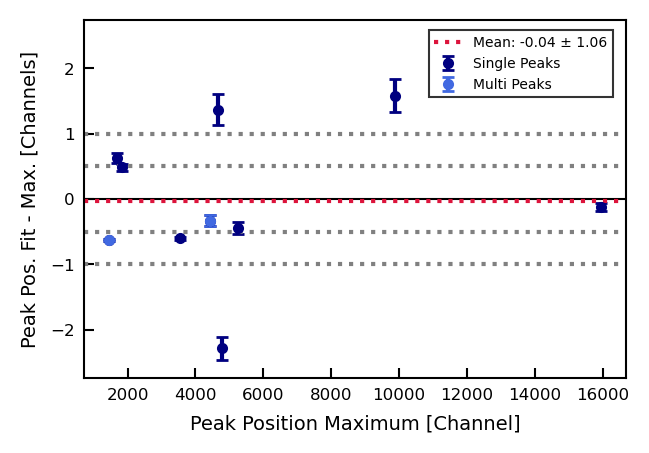

     name     e_lit  e_err_lit  peak_position  peak_position_unc  peak_width  \
0   Pb238   238.632      0.002    1452.368805           0.013606    2.797124   
1   Tl277   277.370      0.020    1688.633622           0.076545    2.951129   
2   Pb300   300.089      0.012    1827.484098           0.057109    2.883003   
3   Tl583   583.187      0.002    3554.397987           0.024547    3.600576   
4   Bi727   727.330      0.010    4433.667286           0.088468    3.930139   
5   Bi763   763.450      0.020    4653.369663           0.242035    4.157343   
6   Bi785   785.370      0.090    4788.713633           0.171520    4.182199   
7   Tl860   860.530      0.020    5246.551764           0.095075    4.154623   
8  Bi1620  1620.738      0.010    9883.583046           0.257435    5.656553   
9  Tl2614  2614.511      0.010   15945.879114           0.064350    6.730338   

   peak_width_unc  chi2_dof  channel_max  
0        0.011871  1.313987       1453.0  
1        0.065978  1.100181      

In [194]:
plt.errorbar(df_calibration.channel_max, df_calibration.peak_position-df_calibration.channel_max, 
             yerr = df_calibration.peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'navy', label = 'Single Peaks')
try:
    plt.errorbar(df_calibration[df_calibration.name == 'Bi727'].channel_max, 
                 df_calibration[df_calibration.name == 'Bi727'].peak_position-df_calibration[df_calibration.name == 'Bi727'].channel_max, 
                 yerr = df_calibration[df_calibration.name == 'Bi727'].peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'royalblue', 
                 label = 'Multi Peaks')
except:
    pass
try:
    plt.errorbar(df_calibration[df_calibration.name == 'Pb238'].channel_max, 
                 df_calibration[df_calibration.name == 'Pb238'].peak_position-df_calibration[df_calibration.name == 'Pb238'].channel_max, 
                 yerr = df_calibration[df_calibration.name == 'Pb238'].peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'royalblue', )
except:
    pass
plt.axhline(y=0, linestyle='-', color = 'k', linewidth = 0.75)
plt.axhline(y=+0.5, linestyle='dotted', color = 'gray')
plt.axhline(y=-0.5, linestyle='dotted', color = 'gray')
plt.axhline(y=+1.0, linestyle='dotted', color = 'gray')
plt.axhline(y=-1.0, linestyle='dotted', color = 'gray')
val_mean_diff = np.mean(df_calibration.peak_position-df_calibration.channel_max)
val_std_diff = np.std(df_calibration.peak_position-df_calibration.channel_max)
plt.axhline(y=val_mean_diff, 
            linestyle='dotted', color = 'crimson', label = 'Mean: '+str(round(val_mean_diff,2))+' ± '+str(round(val_std_diff,2)))
plt.xlabel('Peak Position Maximum [Channel]')
plt.ylabel('Peak Pos. Fit - Max. [Channels]')
val_lim = 1.2*np.max(np.abs(df_calibration.peak_position-df_calibration.channel_max))
plt.ylim(-val_lim, +val_lim)

legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

if save_plots:
    plt.savefig(filename_suffix_save+'_deviation_lines_max_fit.png', bbox_inches='tight')
plt.show()
print(df_calibration)

In [195]:
thr = 5
outlier_check = np.abs(df_calibration.peak_position-df_calibration.channel_max)>thr
if np.any(outlier_check):
    print('Warning: For the following peaks, the peak max. and fit positions differ by more than 1 Channel and are hence removed from the following analysis: '+str(df_calibration[outlier_check].name.tolist()))
    #df_calibration = df_calibration.drop(df_calibration[outlier_check].index.values)
else:
    print('For all peaks, the peak max. and fit positions differ by less than '+str(thr)+' Channel. We hence keep them all for the following analysis.')
    print(df_calibration)

For all peaks, the peak max. and fit positions differ by less than 5 Channel. We hence keep them all for the following analysis.
     name     e_lit  e_err_lit  peak_position  peak_position_unc  peak_width  \
0   Pb238   238.632      0.002    1452.368805           0.013606    2.797124   
1   Tl277   277.370      0.020    1688.633622           0.076545    2.951129   
2   Pb300   300.089      0.012    1827.484098           0.057109    2.883003   
3   Tl583   583.187      0.002    3554.397987           0.024547    3.600576   
4   Bi727   727.330      0.010    4433.667286           0.088468    3.930139   
5   Bi763   763.450      0.020    4653.369663           0.242035    4.157343   
6   Bi785   785.370      0.090    4788.713633           0.171520    4.182199   
7   Tl860   860.530      0.020    5246.551764           0.095075    4.154623   
8  Bi1620  1620.738      0.010    9883.583046           0.257435    5.656553   
9  Tl2614  2614.511      0.010   15945.879114           0.064350    6.7

# Calibration

## Linear fit

In [197]:
popt, pcov = curve_fit(linFunc, df_calibration.peak_position, df_calibration.e_lit, 
                       p0=[np.median(df_calibration.e_lit/df_calibration.peak_position), 0], 
                       bounds=((0, -np.inf),
                               (+np.inf, +np.inf)), 
                       sigma=df_calibration.peak_width, maxfev=10000)
cal_CE_a = popt[0]
print(cal_CE_a)
cal_CE_a_err = np.sqrt(pcov[0, 0])
print(cal_CE_a_err)
cal_CE_b = popt[1]
print('')
print(cal_CE_b)
cal_CE_b_err = np.sqrt(pcov[1, 1])
print(cal_CE_b_err)
cal_CE_cov_ab = pcov[0, 1]
cal_CE = (cal_CE_a, cal_CE_b)

cal_EC_a = 1/cal_CE_a
cal_EC_b = -cal_CE_b/cal_CE_a
cal_EC = (cal_EC_a, cal_EC_b)

with open(filename_suffix_save+'_calibration_parameters.txt', 'w') as writer:
    writer.write("cal_CE_a"+"\n")
    writer.write(str(cal_CE_a)+"\n")
    writer.write("cal_CE_a_err"+"\n")
    writer.write(str(cal_CE_a_err)+"\n")
    writer.write("cal_CE_b"+"\n")
    writer.write(str(cal_CE_b)+"\n")
    writer.write("cal_CE_b_err"+"\n")
    writer.write(str(cal_CE_b_err)+"\n")
    writer.write("cal_CE_cov_ab"+"\n")
    writer.write(str(cal_CE_cov_ab)+"\n")
    
df_calibration
df_calibration.to_csv('Th228_far_calib.txt', sep = ',')

0.16392586059533878
6.953596818083112e-06

0.5325844356607246
0.03260142319278917


In [74]:
reconstr_e = linFunc(df_calibration.peak_position, *cal_CE)
df_calibration['reconstr_e'] = reconstr_e
reconstr_e_err = np.sqrt(cal_CE_b_err**2 + (cal_CE_a_err*df_calibration.peak_position)**2 + 2*(df_calibration.peak_position)*cal_CE_cov_ab)
residuals_e = reconstr_e - df_calibration.e_lit
residuals_e_err = np.sqrt(reconstr_e_err**2 + (df_calibration.e_err_lit)**2)
print(np.mean(residuals_e))

-0.0003295259780941251


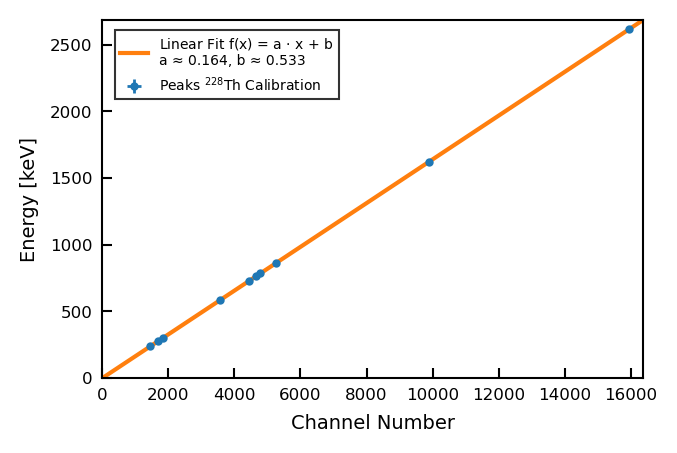

In [75]:
plt.errorbar(df_calibration.peak_position, df_calibration.e_lit, 
             xerr = df_calibration.peak_width, yerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks $^{228}$Th Calibration', linewidth=1)
plt.plot(np.linspace(0,16383,10), linFunc(np.linspace(0,16383,10), *popt), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(popt[0],3))+', b ≈ '+str(round(popt[1],3)))
plt.xlabel('Channel Number')
plt.ylabel('Energy [keV]')
#plt.xscale('log'); plt.yscale('log');
plt.xlim(0, 16383)
plt.ylim(0, linFunc(16383, *popt))
legend = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit.png', bbox_inches='tight')
plt.show()

In [76]:
chi2 = np.sum(residuals_e**2 / residuals_e_err**2)
dof = len(residuals_e)-len(popt)

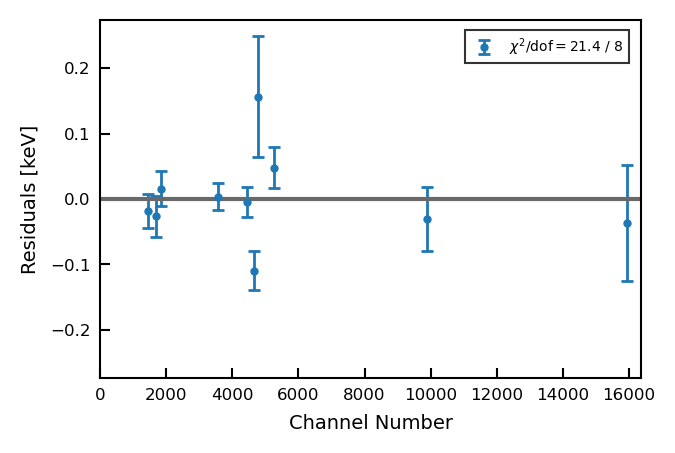

In [77]:
plt.errorbar(df_calibration.peak_position, residuals_e, yerr = residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
plt.axhline(y=np.mean(residuals_e), color = 'dimgray')
plt.xlabel('Channel Number')
plt.ylabel('Residuals [keV]')
val_lim = max(np.abs(1.1*np.max(residuals_e+residuals_e_err)), np.abs(1.1*np.min(residuals_e-residuals_e_err)))
plt.xlim(0, 16383)
plt.ylim(-val_lim, val_lim)
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_residuals.png', bbox_inches='tight')
plt.show()

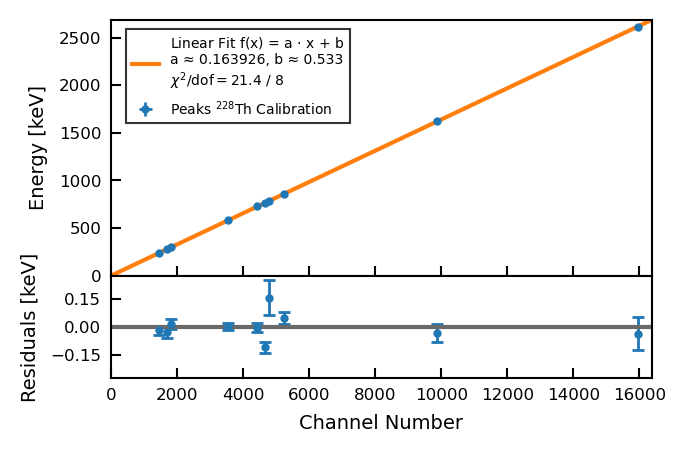

In [78]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.peak_position, df_calibration.e_lit, 
             xerr = df_calibration.peak_width, yerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks $^{228}$Th Calibration', linewidth=1)
ax0.plot(np.linspace(0,16383,10), linFunc(np.linspace(0,16383,10), *popt), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(popt[0],6))+', b ≈ '+str(round(popt[1],3))+
         '\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy [keV]')
ax0.set_ylim(0, linFunc(16383, *popt))

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.peak_position, residuals_e, yerr = residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals_e), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [keV]')
val_lim = max(np.abs(1.1*np.max(residuals_e+residuals_e_err)), np.abs(1.1*np.min(residuals_e-residuals_e_err)))
ax1.set_ylim(-val_lim, val_lim)
ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
plt.xlim(0, 16383)

legend = ax0.legend(loc=2, bbox_to_anchor=(0.015,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_residuals.png', bbox_inches='tight')
plt.show()

In [79]:
print('MCA_ch Residual MCA_ch_error Residual_error')
out = np.array([np.array(df_calibration.peak_position), np.array(residuals_e), 
                np.array(df_calibration.peak_width), np.array(residuals_e_err)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

MCA_ch Residual MCA_ch_error Residual_error
1452.3688051449446 -0.018609279130316736 2.7971238018077487 0.025616692274731553
1688.6336224898105 -0.02669576747263136 2.9511287086296627 0.031697084221064
1827.4840979942928 0.015487923671628323 2.8830031215705407 0.026894284984223707
3554.397987315993 0.003333404774934934 3.6005756748218682 0.02057079314891483
4433.6672858778375 -0.004690133414896991 3.9301385099478967 0.02341837343301035
4653.369662909965 -0.10978890358171611 4.157342790093542 0.02945176756552655
4788.713632693343 0.15658781954812184 4.1821993330493825 0.09263598850937535
5246.551763936346 0.04809749691901288 4.154622970933418 0.030691752575076933
9883.583046385509 -0.03055892009456329 5.656553193728655 0.0489657597178616
15945.879113705052 -0.03645890100051474 6.730337513833219 0.08848277862893728


In [80]:
print('Energy Residual Energy_error Residual_error')
out = np.array([np.array(df_calibration.e_lit), np.array(-cal_EC_a*residuals_e), 
                np.array(df_calibration.e_err_lit), np.array(cal_EC_a*residuals_e_err)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

Energy Residual Energy_error Residual_error
238.632 0.11352253428917419 0.002 0.15626998804031267
277.37 0.16285269069614053 0.02 0.19336231700079484
300.089 -0.09448127107815665 0.012 0.1640637107931001
583.187 -0.020334831629547773 0.002 0.12548839502325454
727.33 0.028611308782296882 0.01 0.14285954240508802
763.45 0.6697473063919845 0.02 0.17966516972102453
785.37 -0.9552356106561407 0.09 0.5651090570636262
860.53 -0.2934100619898196 0.02 0.18722947351694214
1620.738 0.18641915304626577 0.01 0.2987067418162692
2614.511 0.2224109171555049 0.01 0.5397731529826312


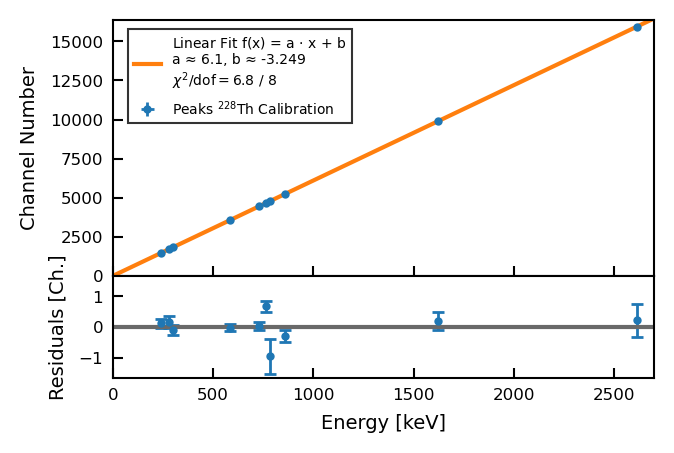

0    0.113523
1    0.162853
2   -0.094481
3   -0.020335
4    0.028611
5    0.669747
6   -0.955236
7   -0.293410
8    0.186419
9    0.222411
dtype: float64 0    0.156270
1    0.193362
2    0.164064
3    0.125488
4    0.142860
5    0.179665
6    0.565109
7    0.187229
8    0.298707
9    0.539773
dtype: float64


0     1452.368805
1     1688.633622
2     1827.484098
3     3554.397987
4     4433.667286
5     4653.369663
6     4788.713633
7     5246.551764
8     9883.583046
9    15945.879114
Name: peak_position, dtype: float64

In [123]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, df_calibration.peak_position, 
             yerr = df_calibration.peak_width, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks $^{228}$Th Calibration', linewidth=1)
ax0.plot(np.linspace(0,2700,10), linFunc(np.linspace(0,2700,10), *cal_EC), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(cal_EC[0],3))+', b ≈ '+str(round(cal_EC[1],3))+
         '\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Channel Number')
ax0.set_ylim(0, 16383)

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, -cal_EC_a*residuals_e, yerr = cal_EC_a*residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(-cal_EC_a*residuals_e), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Residuals [Ch.]')
val_lim = max(np.abs(1.1*np.max(cal_EC_a*(residuals_e+residuals_e_err))), np.abs(1.1*np.min(cal_EC_a*(residuals_e-residuals_e_err))))
ax1.set_ylim(-val_lim, val_lim)
ax1.set_yticks(np.arange(-1, 1.1, step=1))
plt.xlim(0, 2700)

legend = ax0.legend(loc=2, bbox_to_anchor=(0.015,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_inverse_residuals.png', bbox_inches='tight')
plt.show()
print(-cal_EC_a*residuals_e, cal_EC_a*residuals_e_err)
df_calibration.peak_position

## Spectrum

In [82]:
isotope_list = []
for i in df_calibration['name']:
    if i.find('Tl') > -1:
        isotope_list.append('$^{208}$Tl')
    elif i.find('Bi') > -1:
        isotope_list.append('$^{212}$Bi')
    elif i.find('Pb') > -1:
        isotope_list.append('$^{212}$Pb')
df_calibration['isotope'] = isotope_list

In [83]:
df_calibration

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max,reconstr_e,isotope
0,Pb238,238.632,0.002,1452.368805,0.013606,2.797124,0.011871,1.313987,1453.0,238.613391,$^{212}$Pb
1,Tl277,277.370,0.020,1688.633622,0.076545,2.951129,0.065978,1.100181,1688.0,277.343304,$^{208}$Tl
2,Pb300,300.089,0.012,1827.484098,0.057109,2.883003,0.047617,1.150395,1827.0,300.104488,$^{212}$Pb
3,Tl583,583.187,0.002,3554.397987,0.024547,3.600576,0.020904,1.092073,3555.0,583.190333,$^{208}$Tl
4,Bi727,727.330,0.010,4433.667286,0.088468,3.930139,0.077443,1.290583,4434.0,727.325310,$^{212}$Bi
5,Bi763,763.450,0.020,4653.369663,0.242035,4.157343,0.215254,1.141774,4652.0,763.340211,$^{212}$Bi
6,Bi785,785.370,0.090,4788.713633,0.171520,4.182199,0.144335,1.305174,4791.0,785.526588,$^{212}$Bi
7,Tl860,860.530,0.020,5246.551764,0.095075,4.154623,0.079725,1.232518,5247.0,860.578097,$^{208}$Tl
8,Bi1620,1620.738,0.010,9883.583046,0.257435,5.656553,0.213653,1.450512,9882.0,1620.707441,$^{212}$Bi
9,Tl2614,2614.511,0.010,15945.879114,0.064350,6.730338,0.048223,0.786811,15946.0,2614.474541,$^{208}$Tl


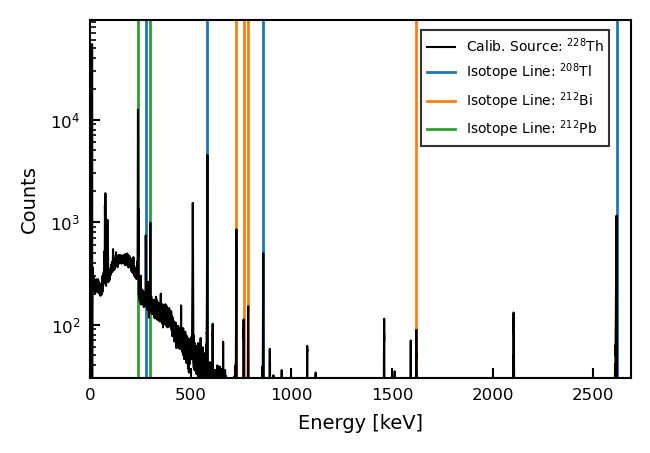

In [84]:
plt.plot(linFunc(df.channel, *cal_CE), df.counts, color = 'black', linewidth = 0.75, label = 'Calib. Source: $^{228}$Th')
for i, line in enumerate(df_calibration[df_calibration['isotope'] == '$^{208}$Tl'].e_lit):
    if i == 0:
        plt.axvline(x = line, color = 'C0', label = 'Isotope Line: $^{208}$Tl', zorder = 0, linewidth = 1)
    else:
        plt.axvline(x = line, color = 'C0', zorder = 0, linewidth = 1)
for i, line in enumerate(df_calibration[df_calibration['isotope'] == '$^{212}$Bi'].e_lit):
    if i == 0:
        plt.axvline(x = line, color = 'C1', label = 'Isotope Line: $^{212}$Bi', zorder = 0, linewidth = 1)
    else:
        plt.axvline(x = line, color = 'C1', zorder = 0, linewidth = 1)
for i, line in enumerate(df_calibration[df_calibration['isotope'] == '$^{212}$Pb'].e_lit):
    if i == 0:
        plt.axvline(x = line, color = 'C2', label = 'Isotope Line: $^{212}$Pb', zorder = 0, linewidth = 1)
    else:
        plt.axvline(x = line, color = 'C2', zorder = 0, linewidth = 1)
plt.yscale('log')
plt.xlim(0,linFunc(16383, *cal_CE))
plt.ylim(bottom = 30)
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(0.6,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_spectrum_lines_marked.png', bbox_inches='tight')
plt.show()

# Resolution

In [85]:
ratio_width_fitlit = cal_CE_a*df_calibration.peak_width/df_calibration.e_err_lit
ratio_width_fitlit

0    229.260463
1     24.188316
2     39.383231
3    295.113733
4     64.425134
5     34.074800
6      7.617451
7     34.052507
8     92.725535
9    110.327637
dtype: float64

In [86]:
df_calibration.peak_width

0    2.797124
1    2.951129
2    2.883003
3    3.600576
4    3.930139
5    4.157343
6    4.182199
7    4.154623
8    5.656553
9    6.730338
Name: peak_width, dtype: float64

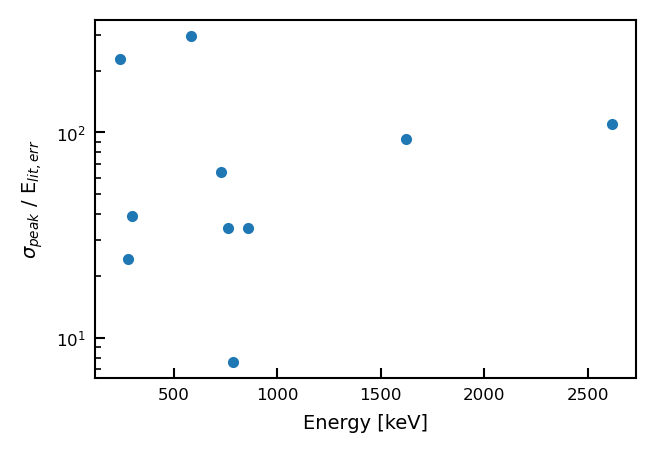

In [87]:
plt.errorbar(df_calibration.e_lit, ratio_width_fitlit, 
            fmt = 'o', ms = 3)
#plt.axhline(y = 20, color = 'gray')
plt.yscale('log')
plt.xlabel('Energy [keV]')
plt.ylabel('$\sigma_{peak}$ / E$_{lit, err}$')
plt.show()

In [88]:
## Remove lines where ratio_width_fitlit<20
#reconstr_e = reconstr_e[ratio_width_fitlit>20]
#reconstr_e_err = reconstr_e_err[ratio_width_fitlit>20]

In [89]:
rel_resol = cal_CE_a*df_calibration.peak_width / reconstr_e
rel_resol_err = rel_resol*np.sqrt((reconstr_e_err/reconstr_e)**2+(cal_CE_a_err/cal_CE_a)**2+(df_calibration.peak_width_unc/df_calibration.peak_width)**2)

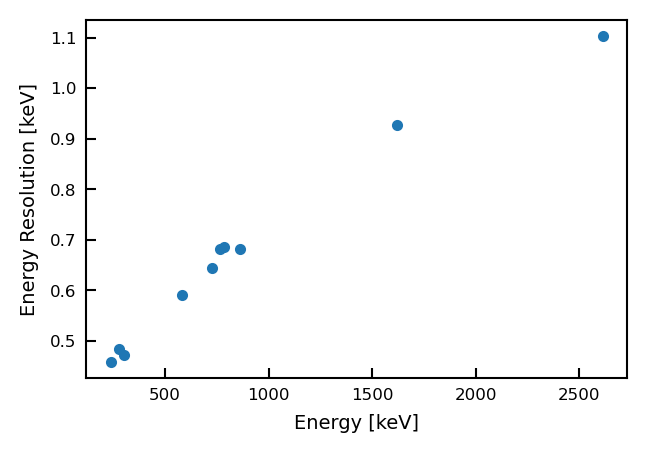

In [90]:
plt.errorbar(df_calibration.e_lit, rel_resol*reconstr_e, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3)
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [keV]')
plt.show()

In [91]:
def relresolFunc(E, a,b,c):
    relresol = np.sqrt(a/E**2 + b/E + c)
    return relresol

In [92]:
popt_relresol, pcov_relresol = curve_fit(relresolFunc, df_calibration.e_lit, rel_resol, 
                       p0=[0.1, 0.1, 0.1], 
                       bounds=((0, 0, 0),
                               (+np.inf, +np.inf, +np.inf)), 
                       sigma=rel_resol_err, maxfev=10000)
print(popt_relresol[0])
print(popt_relresol[1])
print(popt_relresol[2])
print(np.sqrt(np.diag(pcov_relresol)))
reconstr_relresol = relresolFunc(df_calibration.e_lit, *popt_relresol)
residuals = reconstr_relresol - rel_resol
reconstr_relresol_err = 1/2*np.sqrt(popt_relresol[0]**2/df_calibration.e_lit**4 + popt_relresol[1]**2/df_calibration.e_lit**2 + popt_relresol[2]**2)
residuals_err = np.sqrt(reconstr_relresol_err**2 + rel_resol_err**2)
chi2 = np.sum(residuals**2 / residuals_err**2)
dof = len(residuals)-len(popt)

0.11384529793885971
0.0004000892337115606
8.733669279156957e-09
[4.47479584e-03 1.61072566e-05 6.71242678e-09]


[1.13845298e-01 4.00089234e-04 8.73366928e-09]


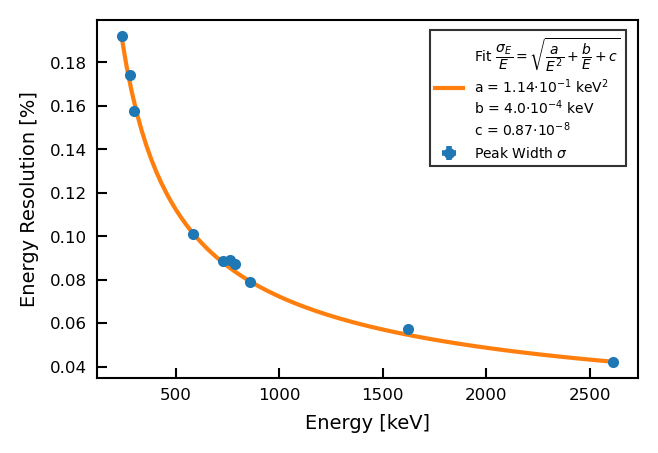

In [93]:
plt.errorbar(df_calibration.e_lit, 100*rel_resol, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
print(popt_relresol)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol), label = 'Fit $\dfrac{\sigma_E}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(1e1*popt_relresol[0],2))+'$\cdot 10^{-1}$ keV$^2$' 
         +'\nb = '+str(round(1e4*popt_relresol[1],2))+'$\cdot 10^{-4}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$')
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit.png', bbox_inches='tight')
plt.show()

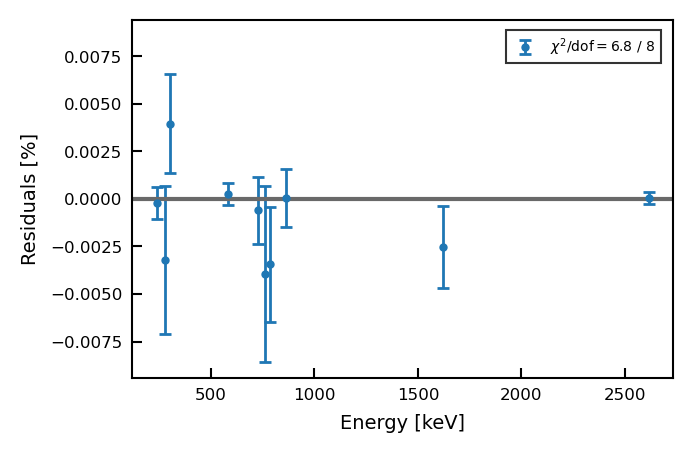

In [94]:
plt.errorbar(df_calibration.e_lit, 100*residuals, yerr = 100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
plt.axhline(y=np.mean(residuals), color = 'dimgray')
plt.xlabel('Energy [keV]')
plt.ylabel('Residuals [%]')
val_lim = max(np.abs(100*1.1*np.max(residuals+residuals_err)), np.abs(100*1.1*np.min(residuals-residuals_err)))
plt.ylim(-val_lim, val_lim)
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_residuals.png', bbox_inches='tight')
plt.show()

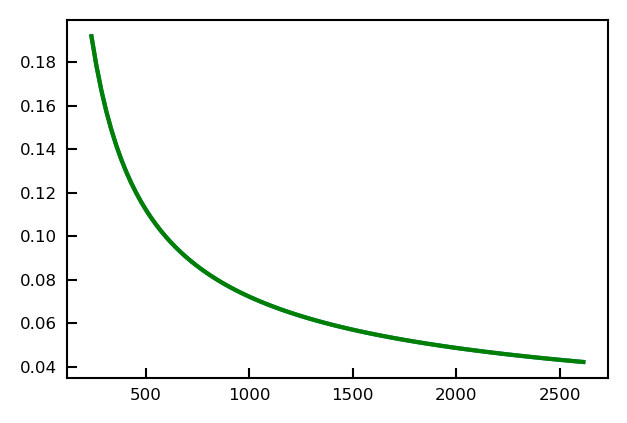

In [95]:
def relresolFunc1(E, a,b,c):
    relresol = np.sqrt(a/E**2 + b/E + c)
    return relresol
a = 0.114
b = 0.000400089234
c = 0.00000000873366928
plt.plot(x_val, 100*relresolFunc1(x_val, *popt_relresol))
plt.plot(x_val, 100*relresolFunc1(x_val, a,b,c), color = 'g')
plt.show()

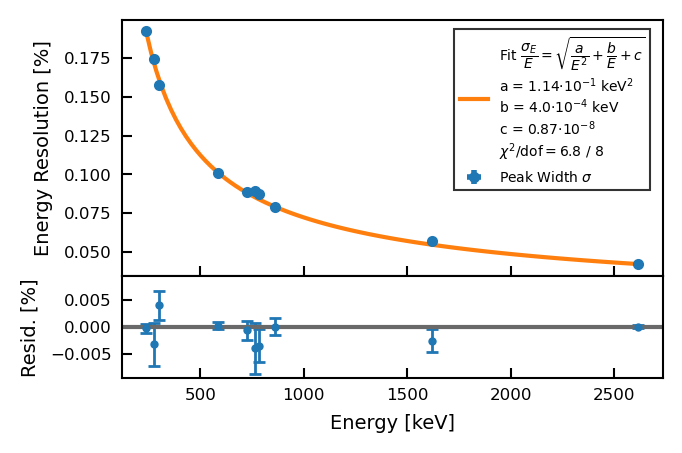

In [96]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, 100*rel_resol, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
ax0.plot(x_val, 100*relresolFunc(x_val, *popt_relresol), label = 'Fit $\dfrac{\sigma_E}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(1e1*popt_relresol[0],2))+'$\cdot 10^{-1}$ keV$^2$' 
         +'\nb = '+str(round(1e4*popt_relresol[1],2))+'$\cdot 10^{-4}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resolution [%]')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, 100*residuals, yerr = 100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Resid. [%]')
val_lim = max(np.abs(100*1.1*np.max(residuals+residuals_err)), np.abs(100*1.1*np.min(residuals-residuals_err)))
ax1.set_ylim(-val_lim, val_lim)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)

legend = ax0.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_residuals.png', bbox_inches='tight')
plt.show()

### as function of MCA

In [97]:
resol = df_calibration.peak_width
resol_err = df_calibration.peak_width_unc

In [98]:
def resolFunc(E, a,b,c):
    resol = np.sqrt(a*(E**2) + b*E + c)
    return resol

In [99]:
popt_relresol[2], popt_relresol[1]/cal_CE_a, popt_relresol[0]/cal_CE_a**2

(8.733669279156957e-09, 0.002440671851643993, 4.236626255304061)

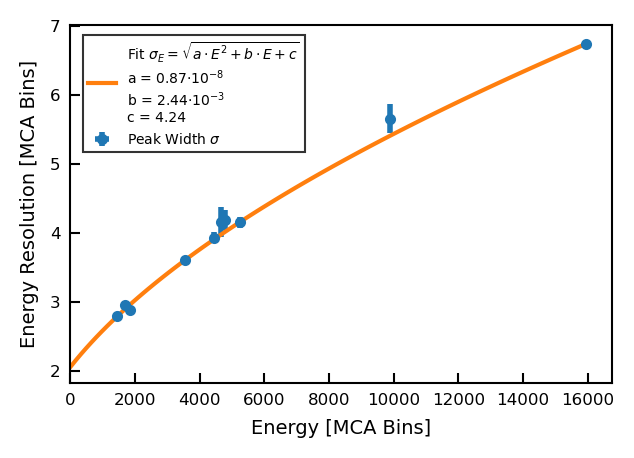

In [100]:
plt.errorbar(df_calibration.peak_position, resol, yerr = resol_err, xerr = df_calibration.peak_position_unc,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
x_val = np.linspace(0, np.array(df_calibration.peak_position)[-1], 100)
plt.plot(x_val, resolFunc(x_val, popt_relresol[2], popt_relresol[1]/cal_CE_a, popt_relresol[0]/cal_CE_a**2), 
         label = 'Fit $\sigma_E = \sqrt{a \cdot E^2 + b \cdot E +c}$'
         +'\na = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$' 
         +'\nb = '+str(round(1e3*popt_relresol[1]/cal_CE_a,2))+'$\cdot 10^{-3}$' 
         +'\nc = '+str(round(1e0*popt_relresol[0]/cal_CE_a**2,2)))
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [MCA Bins]')
plt.ylabel('Energy Resolution [MCA Bins]')
plt.xlim(left = 0)
legend = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_ADC.png', bbox_inches='tight')
plt.show()

In [101]:
residuals_conv = residuals*df_calibration.e_lit
residuals_err_conv = residuals_err*df_calibration.e_lit

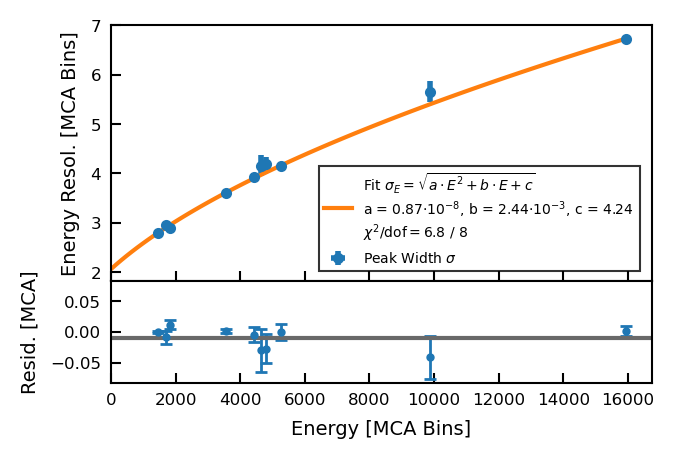

In [102]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.peak_position, resol, yerr = resol_err, xerr = df_calibration.peak_position_unc,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
x_val = x_val = np.linspace(0, np.array(df_calibration.peak_position)[-1], 100)
ax0.plot(x_val, resolFunc(x_val, popt_relresol[2], popt_relresol[1]/cal_CE_a, popt_relresol[0]/cal_CE_a**2), 
         label = 'Fit $\sigma_E = \sqrt{a \cdot E^2 + b \cdot E +c}$'
         +'\na = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$' 
         +', b = '+str(round(1e3*popt_relresol[1]/cal_CE_a,2))+'$\cdot 10^{-3}$' 
         +', c = '+str(round(1e0*popt_relresol[0]/cal_CE_a**2,2))
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resol. [MCA Bins]')
ax0.set_xlim(left = 0)

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.peak_position, residuals_conv, yerr = residuals_err_conv,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals_conv), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [MCA Bins]')
ax1.set_ylabel('Resid. [MCA]')
val_lim = max(np.abs(1.1*np.max(residuals_conv+residuals_err_conv)), np.abs(1.1*np.min(residuals_conv-residuals_err_conv)))
ax1.set_ylim(-val_lim, val_lim)
ax1.set_xlim(left = 0)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)

legend = ax0.legend(loc=4, bbox_to_anchor=(0.99,0.01), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_residuals_adc.png', bbox_inches='tight')
plt.show()

In [103]:
print('MCA_ch Resolution MCA_ch_error Resolution_error')
out = np.array([np.array(df_calibration.peak_position), np.array(resol), 
                np.array(df_calibration.peak_width), np.array(resol_err)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

MCA_ch Resolution MCA_ch_error Resolution_error
1452.3688051449446 2.7971238018077487 2.7971238018077487 0.011870775529732302
1688.6336224898105 2.9511287086296627 2.9511287086296627 0.06597814414034703
1827.4840979942928 2.8830031215705407 2.8830031215705407 0.04761720607344066
3554.397987315993 3.6005756748218682 3.6005756748218682 0.020903625541256392
4433.6672858778375 3.9301385099478967 3.9301385099478967 0.07744325342542956
4653.369662909965 4.157342790093542 4.157342790093542 0.21525384945120843
4788.713632693343 4.1821993330493825 4.1821993330493825 0.1443350243826582
5246.551763936346 4.154622970933418 4.154622970933418 0.07972478278552077
9883.583046385509 5.656553193728655 5.656553193728655 0.21365332579266225
15945.879113705052 6.730337513833219 6.730337513833219 0.048222590548784444


In [104]:
print('MCA_ch Residual MCA_ch_error Residual_error')
out = np.array([np.array(df_calibration.peak_position), np.array(residuals_conv), 
                np.array(df_calibration.peak_width), np.array(residuals_err_conv)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

MCA_ch Residual MCA_ch_error Residual_error
1452.3688051449446 -0.0004991211903455355 2.7971238018077487 0.001971529612511747
1688.6336224898105 -0.008955040878129386 2.9511287086296627 0.010820465696297868
1827.4840979942928 0.011878068530136093 2.8830031215705407 0.007810273328893307
3554.397987315993 0.0015043254434794749 3.6005756748218682 0.0034340017283730263
4433.6672858778375 -0.00436300930678343 3.9301385099478967 0.01269689472069635
4653.369662909965 -0.030146474661405333 4.157342790093542 0.03529141055944358
4788.713632693343 -0.02706449212634654 4.1821993330493825 0.023656509349592965
5246.551763936346 0.0006047251350486899 4.154622970933418 0.01306996707395902
9883.583046385509 -0.041142678695081564 5.656553193728655 0.03502458811058863
15945.879113705052 0.0010557734905283329 6.730337513833219 0.007907834380555513


## Resolution FWHM

In [105]:
sigma_to_fwhm = 2*np.sqrt(2*np.log(2))
print('factor Gaussian sigma to FWHM: '+str(sigma_to_fwhm))

factor Gaussian sigma to FWHM: 2.3548200450309493


In [106]:
popt_relresol_fwhm = popt_relresol*sigma_to_fwhm**2
popt_relresol_fwhm

array([6.31292378e-01, 2.21856579e-03, 4.84297459e-08])

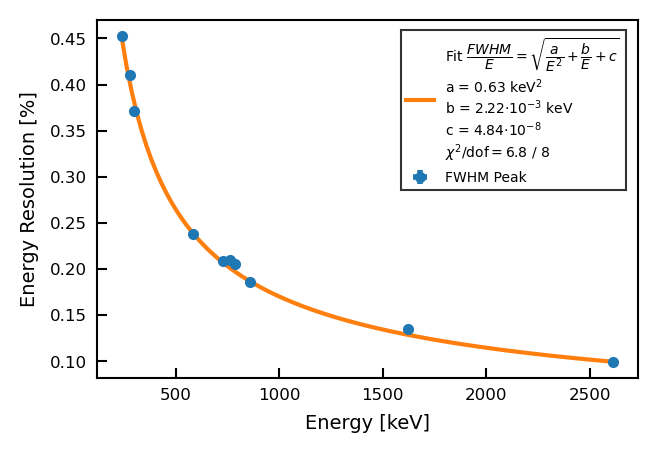

In [107]:
plt.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit.png', bbox_inches='tight')
plt.show()

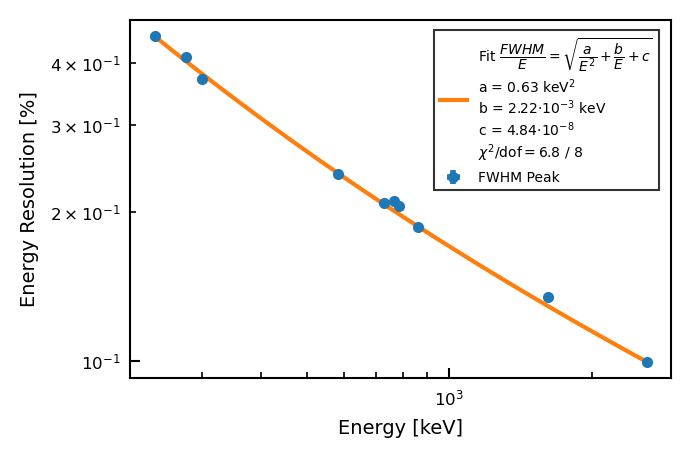

In [108]:
plt.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_loglog.png', bbox_inches='tight')
plt.show()

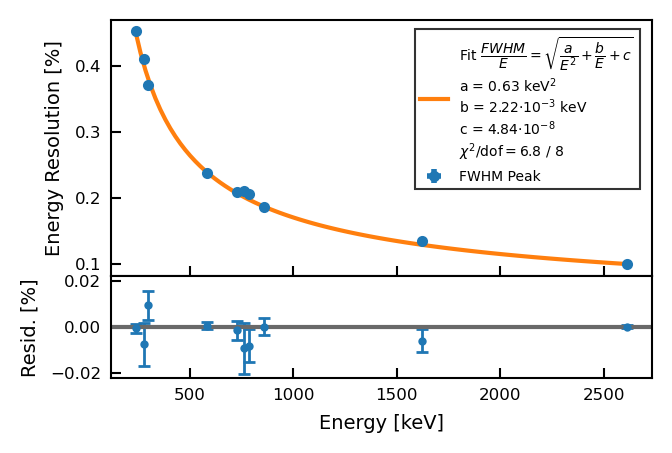

In [109]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
ax0.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resolution [%]')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*residuals, yerr = sigma_to_fwhm*100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Resid. [%]')
val_lim = max(np.abs(sigma_to_fwhm*100*1.1*np.max(residuals+residuals_err)), np.abs(sigma_to_fwhm*100*1.1*np.min(residuals-residuals_err)))
ax1.set_ylim(-val_lim, val_lim)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)

legend = ax0.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_residuals.png', bbox_inches='tight')
plt.show()

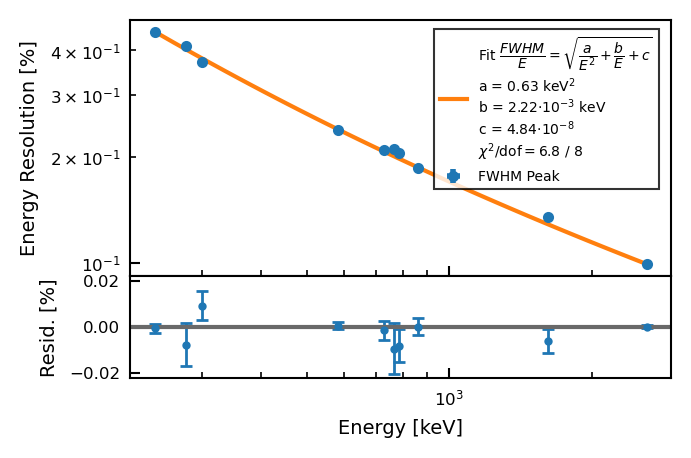

In [110]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
ax0.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resolution [%]')
ax0.set_xscale('log'); ax0.set_yscale('log');

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*residuals, yerr = sigma_to_fwhm*100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Resid. [%]')
val_lim = max(np.abs(sigma_to_fwhm*100*1.1*np.max(residuals+residuals_err)), np.abs(sigma_to_fwhm*100*1.1*np.min(residuals-residuals_err)))
ax1.set_ylim(-val_lim, val_lim)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)
ax1.set_xscale('log'); 

legend = ax0.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_residuals_loglog.png', bbox_inches='tight')
plt.show()

In [111]:
'''matplotlib.rcParams['figure.figsize'] = (3.4908516673585166/1.2, 2.327234444905678)

plt.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_aspectratio.png', bbox_inches='tight')
plt.show()''';

# Other Stuff

In [112]:
print(cal_CE)
print(cal_EC)

(0.16392586059533878, 0.5325844356607246)
(6.10031874390193, -3.2489348155715496)


In [113]:
linFunc(np.array([100, 2700]), *cal_EC)

array([  606.78293957, 16467.61167372])

In [114]:
linFunc(np.array([0, 16383]), *cal_CE)

array([5.32584436e-01, 2.68612996e+03])

In [115]:
Energy_check = 1332.49
Energy_check*relresolFunc(Energy_check, *popt_relresol_fwhm)

1.9166370447322183

In [116]:
cal_202105_CE_a = 0.16480422280063092
cal_202105_CE_b = 0.49977182490554006
cal_202105_CE = (cal_202105_CE_a, cal_202105_CE_b)
cal_202105_EC_a = 1/cal_202105_CE_a
cal_202105_EC_b = -cal_202105_CE_b/cal_202105_CE_a
cal_202105_EC = (cal_202105_EC_a, cal_202105_EC_b)

def func_e_to_adc(x = np.array([100, 2700]), a = cal_202105_EC_a, b = cal_202105_EC_b):
    res = a*x+b
    return res
def func_adc_to_e(x = np.array([0, 16383]), a = cal_202105_CE_a, b = cal_202105_CE_b):
    res = a*x+b
    return res

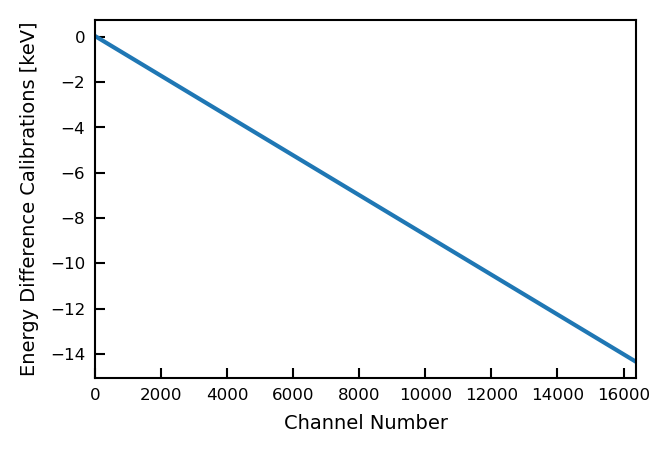

In [117]:
x_list = np.linspace(0,16383,10)
plt.plot(x_list, linFunc(x_list, *popt) - func_adc_to_e(x_list))
plt.xlim(0,16383)
plt.xlabel('Channel Number')
plt.ylabel('Energy Difference Calibrations [keV]')
if save_plots:
    plt.savefig(filename_suffix_save+'_diff_to_calib202105.png', bbox_inches='tight')
plt.show()

In [118]:
p_resol_202105 = (8.97573110e-01, 2.29320769e-03, 1.52084498e-26)

def relresolFunc_old(E, a=p_resol_202105[0], b=p_resol_202105[1], c=p_resol_202105[2]):
    relresol = np.sqrt(a/E**2 + b/E + c)
    return relresol

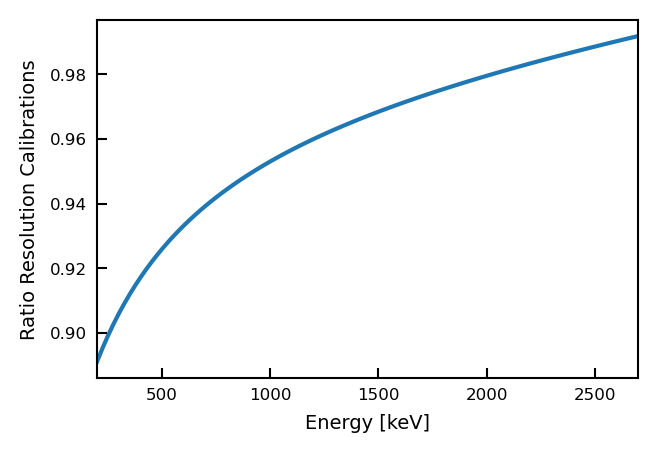

In [119]:
x_list = np.linspace(200,2700,100)

plt.plot(x_list, relresolFunc(x_list, *popt_relresol_fwhm) / relresolFunc_old(x_list))
plt.xlim(200,2700)
plt.xlabel('Energy [keV]')
plt.ylabel('Ratio Resolution Calibrations')
if save_plots:
    plt.savefig(filename_suffix_save+'_ratioresol_to_calib202105.png', bbox_inches='tight')
plt.show()